# CDL by tensorflow

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>



In [59]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [5]:
import pickle
import tensorflow as tf
import time

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import caffeine
#init random seed
np.random.seed(5)



## Step 1 : Generate Rating Matrix

In [7]:
# program_df = pd.read_csv("/Users/krishna/Dropbox/Data/Data/Program/correct File/csvwithHeaders/part-00000-024e4c6e-680c-49e1-8e20-667765b52332-c000.csv")
AllData_test_run = pq.read_table("/Users/krishna/Dropbox/Data/final_datasets/feature_enginnering/user_program_features/stage2/part-00000-c8f21366-ffaf-491f-837c-abaa906916b3-c000.snappy.parquet")
AllData_test_run_df = AllData_test_run.to_pandas()
AllData_test_run_df.replace("NULL", np.nan,inplace=True)
# AllData_test_run_df.replace(np.nan, 0,inplace=True)
AllData_test_run_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3494276 entries, 0 to 3494275
Data columns (total 25 columns):
USER                              int64
PROGRAM_WATCH_RATIO               float64
EPISODES_WATCHED                  int64
USER_WATCH_FREQUENCY              float64
USER_PROGRAM_PREFERANCE_METRIC    float64
MASTER_TITLE                      object
EVENT_DATE                        object
CATEGORY_ID                       object
SUBCATEGORY_ID                    object
RUNTIME                           object
EPISODE_COUNT                     object
day                               object
week_text                         object
week_encoded                      object
month                             object
vwp_days                          object
weekend                           object
daypart                           object
weekOfTheYear                     object
EVENT_END_DATE                    object
airStartDate                      object
airStartTime             

### Transpose the original Matrix to for Rating Matrix

In [8]:
AllData_test_run_pivot_df = AllData_test_run_df[["USER","MASTER_TITLE","USER_PROGRAM_PREFERANCE_METRIC"]].pivot("USER", "MASTER_TITLE", "USER_PROGRAM_PREFERANCE_METRIC")
AllData_test_run_pivot_df.replace("NULL", np.nan,inplace=True)
AllData_test_run_pivot_df.replace(np.nan, 0,inplace=True)
AllData_test_run_pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292601 entries, 5046682 to 9145409
Columns: 259 entries, A Taste of History to tasteMAKERS
dtypes: float64(259)
memory usage: 580.4 MB


In [11]:
AllData_test_run_pivot_df_Original = AllData_test_run_pivot_df.copy()

### Making one of the series Blank

In [12]:
AllData_test_run_pivot_df["The Big Bang Theory"] = 0.0
AllData_test_run_pivot_df.head()

## Step 2 : Generate document-term matrix

### Pre-processing:

In [14]:
import pickle
pickle_in = open("/Users/krishna/BDA03/AllSpark_Workspace/Project_Analysis/data_combined_265_0_articles_Jun24.pickle","rb")
# data_combined_top20_Jun28 = pickle.load(pickle_in)

data_combined = pickle.load(pickle_in)

len(data_combined)

# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(data_combined.Data.apply(round1))
# data_clean

# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean.Data.apply(round2))
# data_clean

data_clean.head()

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import stem

np.random.seed(2018)
import nltk
nltk.download('wordnet')
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def return_to_str(text):
    return ' '.join(text)

# print(preprocess(data_clean['Data'][0]))
data_clean = pd.DataFrame(data_clean.Data.apply(preprocess))
data_clean = pd.DataFrame(data_clean.Data.apply(return_to_str))



[nltk_data] Downloading package wordnet to /Users/krishna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
data_clean.head()

,Data
A Taste of History,tast gustatori percept gustat adjectiv form gu...
ALVINNN!!! and the Chipmunks,alvin chipmunk styliz alvinnn chipmunk america...
Alaska: The Last Frontier: The Frozen Edge,alaska frontier american realiti cabl televis ...
America Says,america say american televis game host john mi...
America's Heartland,america heartland televis program unit state a...
America's Test Kitchen,america test kitchen halfhour cook distribut p...
American Pickers,american picker american realiti televis seri ...
American Woodshop,wbgutv public broadcast servic member televis ...
Americas Now,cgtn america american version cgtn cgtn collec...
Arthur,arthur common masculin give etymolog disput po...


### CountVectorizer for document-term Matrix:

In [16]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.Data)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,aaba,aadvanc,aagaard,aaib,aakaam,aalborg,aaliyah,aaliyahdont,aaliyahfin,aaqib,...,西北政法大学,西北政法学院,超级飞侠,长安校区,陕北公学,陕西本科普通高校名单,雁塔校区,슈퍼윙스,크리미널,할아버지
A Taste of History,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALVINNN!!! and the Chipmunks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alaska: The Last Frontier: The Frozen Edge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
America Says,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
America's Heartland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
America's Test Kitchen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Pickers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Woodshop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Americas Now,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arthur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
data_dtm.shape

(259, 61667)

#### Rename the data :

In [21]:
item_infomation_matrix = np.array(data_dtm)
rating_matrix = np.array(AllData_test_run_pivot_df)

In [22]:
item_infomation_matrix.shape

(259, 61667)

## Step 3 : CDL - Custom function Declarations
- mask  
- add_noise  
- CDL Class 

In [26]:
#### masking noise 
#apply SDAE : we hope to reconstruct item information by masking nosie
def mask(corruption_level ,size):
    mask = np.random.binomial(1, 1 - corruption_level, [size[0],size[1]])
    return mask

def add_noise(x , corruption_level ):
    x = x * mask(corruption_level , x.shape)
    return x

In [30]:
class CDL():
    def __init__(self , rating_matrix , item_infomation_matrix, n_latent, lambda_w, lambda_n, lambda_u,lambda_v,epochs, batch_size):
        
        # model參數設定
        self.n_input = item_infomation_matrix.shape[1]
        self.n_hidden1 = 1600
        self.n_hidden2 = 800
        self.n_hidden3 = 400
        self.n_hidden4 = 200
        self.n_hidden5 = 50        
        self.k = n_latent# 50
        
        self.lambda_w = lambda_w #0.1
        self.lambda_n = lambda_n # 10
        self.lambda_u = lambda_u #1
        self.lambda_v = lambda_v #10
        
        self.drop_ratio = 0.1
        self.learning_rate = 0.01
        self.epochs = epochs #200
        self.batch_size = batch_size #256
        
        self.a = 1
        self.b =0.01
        self.P = 1
        
        self.num_u = rating_matrix.shape[0]
        self.num_v = rating_matrix.shape[1]
        
        self.Weights = {
            'w1' : tf.Variable(tf.truncated_normal( [self.n_input , self.n_hidden1] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w2' : tf.Variable(tf.truncated_normal( [self.n_hidden1 , self.n_hidden2] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w3' : tf.Variable(tf.truncated_normal( [self.n_hidden2 , self.n_hidden3] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w4' : tf.Variable(tf.truncated_normal( [self.n_hidden3 , self.n_hidden4] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w5' : tf.Variable(tf.truncated_normal( [self.n_hidden4 , self.n_hidden5] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w6' : tf.Variable(tf.truncated_normal( [self.n_hidden5 , self.n_hidden4] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w7' : tf.Variable(tf.truncated_normal( [self.n_hidden4 , self.n_hidden3] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w8' : tf.Variable(tf.truncated_normal( [self.n_hidden3 , self.n_hidden2] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w9' : tf.Variable(tf.truncated_normal( [self.n_hidden2 , self.n_hidden1] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),               
            'w10' : tf.Variable(tf.truncated_normal( [self.n_hidden1 , self.n_input] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w)))               
        }
        self.Biases = {
            'b1' : tf.Variable( tf.zeros(shape=self.n_hidden1) ),
            'b2' : tf.Variable( tf.zeros(shape=self.n_hidden2) ),
            'b3' : tf.Variable( tf.zeros(shape=self.n_hidden3) ),
            'b4' : tf.Variable( tf.zeros(shape=self.n_hidden4) ),
            'b5' : tf.Variable( tf.zeros(shape=self.n_hidden5) ),
            'b6' : tf.Variable( tf.zeros(shape=self.n_hidden4) ),
            'b7' : tf.Variable( tf.zeros(shape=self.n_hidden3) ),            
            'b8' : tf.Variable( tf.zeros(shape=self.n_hidden2) ),            
            'b9' : tf.Variable( tf.zeros(shape=self.n_hidden1) ),            
            'b10' : tf.Variable( tf.zeros(shape=self.n_input) )                
        }
        
        self.item_infomation_matrix = item_infomation_matrix
        
        self.rating_matrix = rating_matrix
        
#         for i in range(self.num_u):
#             if len(np.where(self.rating_matrix[i,:]>0)[0])>0 :
# #                 x = np.random.choice(np.where(self.rating_matrix[i,:]>0)[0] , self.P)
#                 x = np.where(self.rating_matrix[i,:]>0)[0]
#             else :
#                 continue 
#             self.rating_matrix[i,:].fill(0)
#             self.rating_matrix[i,x] = 1
        
        self.confidence = np.mat(np.ones(self.rating_matrix.shape)) * self.b
        self.confidence[np.where(self.rating_matrix>0)] = self.a
        
    def encoder(self , x , drop_ratio):
        w1 = self.Weights['w1']
        b1 = self.Biases['b1']
        L1 = tf.nn.sigmoid( tf.matmul(x,w1) + b1 )
        L1 = tf.nn.dropout( L1 , keep_prob= 1 - drop_ratio )
        
        w2 = self.Weights['w2']
        b2 = self.Biases['b2']
        L2 = tf.nn.sigmoid( tf.matmul(L1,w2) + b2 )
        L2 = tf.nn.dropout(L2 , keep_prob= 1 - drop_ratio)

        w3 = self.Weights['w3']
        b3 = self.Biases['b3']
        L3 = tf.nn.sigmoid( tf.matmul(L2,w3) + b3 )
        L3 = tf.nn.dropout(L3 , keep_prob= 1 - drop_ratio)

        w4 = self.Weights['w4']
        b4 = self.Biases['b4']
        L4 = tf.nn.sigmoid( tf.matmul(L3,w4) + b4 )
        L4 = tf.nn.dropout(L4 , keep_prob= 1 - drop_ratio)

        w5 = self.Weights['w5']
        b5 = self.Biases['b5']
        L5 = tf.nn.sigmoid( tf.matmul(L4,w5) + b5 )
        L5 = tf.nn.dropout(L5 , keep_prob= 1 - drop_ratio)
        
        return L5
    
    def decoder(self , x , drop_ratio):
        w6 = self.Weights['w6']
        b6 = self.Biases['b6']
        L6 = tf.nn.sigmoid(tf.matmul(x,w6) + b6)
        L6 = tf.nn.dropout(L6 , keep_prob= 1 - drop_ratio)

        w7 = self.Weights['w7']
        b7 = self.Biases['b7']
        L7 = tf.nn.sigmoid(tf.matmul(L6,w7) + b7)
        L7 = tf.nn.dropout(L7 , keep_prob= 1 - drop_ratio)

        w8 = self.Weights['w8']
        b8 = self.Biases['b8']
        L8 = tf.nn.sigmoid(tf.matmul(L7,w8) + b8)
        L8 = tf.nn.dropout(L8 , keep_prob= 1 - drop_ratio)

        w9 = self.Weights['w9']
        b9 = self.Biases['b9']
        L9 = tf.nn.sigmoid(tf.matmul(L8,w9) + b9)
        L9 = tf.nn.dropout(L9 , keep_prob= 1 - drop_ratio)

        w10 = self.Weights['w10']
        b10 = self.Biases['b10']
        L10 = tf.nn.sigmoid(tf.matmul(L9,w10) + b10)
        L10 = tf.nn.dropout(L10 , keep_prob= 1 - drop_ratio)

        return L10
    
#     def only_MF(self):
#         self.C = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
#         self.R = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
#         self.drop_ratio = tf.placeholder(tf.float32)
#         self.model_batch_data_idx = tf.placeholder( tf.int32 , shape=None )
        
#         batch_size = tf.cast(tf.shape(self.R)[1], tf.int32)
        
        
#         self.V = tf.Variable( tf.zeros(shape=[self.num_v, self.k], dtype=tf.float32 ) ) 
#         self.U = tf.Variable( tf.zeros(shape=[self.num_u, self.k], dtype=tf.float32 ) )
        
#         batch_V = tf.reshape(tf.gather(self.V, self.model_batch_data_idx), shape=[batch_size, self.k])
        
#         loss_1 = self.lambda_u * tf.nn.l2_loss( self.U ) 
#         loss_2 = tf.reduce_sum(tf.multiply(self.C ,
#                                     tf.square(self.R - tf.matmul(self.U , batch_V , transpose_b=True))) 
#                                 )
        
#         self.loss = loss_1 + loss_2 
#         self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def build_model(self):
        
        self.X_0 = tf.placeholder(tf.float32 , shape=(None , self.n_input))
        self.X_c = tf.placeholder(tf.float32 , shape=(None , self.n_input))
        self.C = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
        self.R = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
        self.drop_ratio = tf.placeholder(tf.float32)
        self.model_batch_data_idx = tf.placeholder( tf.int32 , shape=None )
        #SDAE item factor
        V_sdae = self.encoder( self.X_0 , self.drop_ratio )
        
        #SDAE output 
        sdae_output = self.decoder( V_sdae , self.drop_ratio )

        batch_size = tf.cast(tf.shape(self.X_0)[0], tf.int32)
        
        
        self.V = tf.Variable( tf.zeros(shape=[self.num_v, self.k], dtype=tf.float32 ) ) 
        self.U = tf.Variable( tf.zeros(shape=[self.num_u, self.k], dtype=tf.float32 ) )
        
        batch_V = tf.reshape(tf.gather(self.V, self.model_batch_data_idx), shape=[batch_size, self.k])
        
        loss_1 = self.lambda_u * tf.nn.l2_loss( self.U ) 
        loss_2 = self.lambda_w * 1/2 * tf.reduce_sum([tf.nn.l2_loss(w)+tf.nn.l2_loss(b) for w,b in zip(self.Weights.values() , self.Biases.values())])
        loss_3 = self.lambda_v * tf.nn.l2_loss(batch_V - V_sdae)
        loss_4 = self.lambda_n * tf.nn.l2_loss(sdae_output - self.X_c)
        loss_5 = tf.reduce_sum(tf.multiply(self.C ,
                                           tf.square(self.R - tf.matmul(self.U , batch_V , transpose_b=True))
                                          ) 
                                )
        
        self.loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def train_model(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        start_time = time.time()
        
        random_idx = np.random.permutation(self.num_v)
        
        self.item_infomation_matrix_noise = add_noise(self.item_infomation_matrix , 0.3)
        
        for epoch in range(self.epochs):
            batch_cost = 0
            for i in range(0 , self.item_infomation_matrix.shape[0] , self.batch_size):
                
                batch_idx = random_idx[i:i+self.batch_size]
                _ , loss = self.sess.run([self.optimizer, self.loss] , 
                                            feed_dict={self.X_0 : self.item_infomation_matrix_noise[batch_idx,:] , 
                                                       self.X_c : self.item_infomation_matrix[batch_idx,:] , 
                                                       self.R : self.rating_matrix[: , batch_idx], 
                                                       self.C : self.confidence[: , batch_idx], 
                                                       self.drop_ratio : 0.1 ,
                                                       self.model_batch_data_idx  : batch_idx })
                batch_cost = batch_cost + loss

            print ("Training //", "Epoch %d //" % (epoch+1), " Total cost = {:.2f}".format(batch_cost), "Elapsed time : %d sec" % (time.time() - start_time))
            
        return self.sess.run((tf.matmul(self.U, self.V, transpose_b=True)))

### Model Building :

In [56]:
n_latent_array = [50]
lambda_w_array = [10.0]
lambda_n_array = [0.1,10.0]
lambda_u_array = [0.1,10.0]
lambda_v_array = [0.1,10.0]
epochs = [500]
batch_size = [64]
combination_array = []

for g in range(len(n_latent_array)):
    for h in range(len(lambda_w_array)):
        for i in range(len(lambda_n_array)):
            for j in range(len(lambda_u_array)):
                for k in range(len(lambda_v_array)):
                    for l in range(len(epochs)):
                        for m in range(len(batch_size)):
                            combination_array.append([n_latent_array[g],
                                                      lambda_w_array[h],
                                                      lambda_n_array[i],
                                                      lambda_u_array[j],
                                                      lambda_v_array[k],
                                                      epochs[l],
                                                      batch_size[m]]
                                                    )
R_train = rating_matrix.copy()
result_array,CDL_array = [],[]
for i in range(len(combination_array)):
    n_lat = combination_array[i][0]
    lam_w = combination_array[i][1]
    lam_n = combination_array[i][2]
    lam_u = combination_array[i][3]
    lam_v = combination_array[i][4]    
    epoch = combination_array[i][5]
    batch = combination_array[i][6]
    print('Model - {} : Creating model for \n{} - topics,\n{} - lambda_w, \n{} - lambda_n, \n{} - lambda_u, \n{} - lambda_v, \n{} - epochs, \n{} - batchsize'.\
          format(i,n_lat,lam_w,lam_n,lam_u,lam_v,epoch,batch))
    cdl_model = CDL(R_train,item_infomation_matrix,n_lat,lam_w,lam_n,lam_u,lam_v,epoch, batch)
    cdl_model.build_model()
    result_array.append(cdl_model.train_model())
    print('Model - {} : Done'.format(i))
#     CDL_array.append(cdl_model)

Model - 0 : Creating model for 
50 - topics,
10.0 - lambda_w, 
0.1 - lambda_n, 
0.1 - lambda_u, 
0.1 - lambda_v, 
500 - epochs, 
64 - batchsize


W0721 14:06:41.403065 4550190528 deprecation.py:506] From <ipython-input-26-c84ad1387d7f>:75: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Training // Epoch 1 //  Total cost = 15193111.88 Elapsed time : 13 sec
Training // Epoch 2 //  Total cost = 5992517.31 Elapsed time : 23 sec
Training // Epoch 3 //  Total cost = 2609642.39 Elapsed time : 33 sec
Training // Epoch 4 //  Total cost = 1819262.47 Elapsed time : 43 sec
Training // Epoch 5 //  Total cost = 1688660.12 Elapsed time : 53 sec
Training // Epoch 6 //  Total cost = 1579705.20 Elapsed time : 63 sec
Training // Epoch 7 //  Total cost = 1424225.95 Elapsed time : 73 sec
Training // Epoch 8 //  Total cost = 1282419.76 Elapsed time : 84 sec
Training // Epoch 9 //  Total cost = 1191287.96 Elapsed time : 93 sec
Training // Epoch 10 //  Total cost = 1146208.32 Elapsed time : 103 sec
Training // Epoch 11 //  Total cost = 1125038.27 Elapsed time : 113 sec
Training // Epoch 12 //  Total cost = 1113089.58 Elapsed time : 122 sec
Training // Epoch 13 //  Total cost = 1102933.20 Elapsed time : 132 sec
Training // Epoch 14 //  Total cost = 1096697.50 Elapsed time : 142 sec
Training 

Training // Epoch 115 //  Total cost = 1164123.02 Elapsed time : 1132 sec
Training // Epoch 116 //  Total cost = 1161267.95 Elapsed time : 1142 sec
Training // Epoch 117 //  Total cost = 1160377.77 Elapsed time : 1152 sec
Training // Epoch 118 //  Total cost = 1157224.42 Elapsed time : 1162 sec
Training // Epoch 119 //  Total cost = 1155132.91 Elapsed time : 1172 sec
Training // Epoch 120 //  Total cost = 1150230.75 Elapsed time : 1181 sec
Training // Epoch 121 //  Total cost = 1147223.14 Elapsed time : 1191 sec
Training // Epoch 122 //  Total cost = 1143211.01 Elapsed time : 1201 sec
Training // Epoch 123 //  Total cost = 1141936.52 Elapsed time : 1211 sec
Training // Epoch 124 //  Total cost = 1140404.00 Elapsed time : 1220 sec
Training // Epoch 125 //  Total cost = 1138229.84 Elapsed time : 1230 sec
Training // Epoch 126 //  Total cost = 1136121.63 Elapsed time : 1240 sec
Training // Epoch 127 //  Total cost = 1134092.36 Elapsed time : 1249 sec
Training // Epoch 128 //  Total cost =

Training // Epoch 226 //  Total cost = 1107011.77 Elapsed time : 2218 sec
Training // Epoch 227 //  Total cost = 1105663.81 Elapsed time : 2227 sec
Training // Epoch 228 //  Total cost = 1105439.04 Elapsed time : 2237 sec
Training // Epoch 229 //  Total cost = 1104060.73 Elapsed time : 2246 sec
Training // Epoch 230 //  Total cost = 1103000.34 Elapsed time : 2256 sec
Training // Epoch 231 //  Total cost = 1102239.81 Elapsed time : 2266 sec
Training // Epoch 232 //  Total cost = 1102467.79 Elapsed time : 2275 sec
Training // Epoch 233 //  Total cost = 1101149.66 Elapsed time : 2285 sec
Training // Epoch 234 //  Total cost = 1103222.06 Elapsed time : 2294 sec
Training // Epoch 235 //  Total cost = 1102333.74 Elapsed time : 2304 sec
Training // Epoch 236 //  Total cost = 1101864.93 Elapsed time : 2314 sec
Training // Epoch 237 //  Total cost = 1100730.03 Elapsed time : 2323 sec
Training // Epoch 238 //  Total cost = 1101468.61 Elapsed time : 2333 sec
Training // Epoch 239 //  Total cost =

Training // Epoch 337 //  Total cost = 1108824.15 Elapsed time : 3303 sec
Training // Epoch 338 //  Total cost = 1106990.61 Elapsed time : 3313 sec
Training // Epoch 339 //  Total cost = 1107053.85 Elapsed time : 3323 sec
Training // Epoch 340 //  Total cost = 1105154.21 Elapsed time : 3332 sec
Training // Epoch 341 //  Total cost = 1106189.82 Elapsed time : 3342 sec
Training // Epoch 342 //  Total cost = 1104573.96 Elapsed time : 3352 sec
Training // Epoch 343 //  Total cost = 1106193.88 Elapsed time : 3362 sec
Training // Epoch 344 //  Total cost = 1104996.45 Elapsed time : 3372 sec
Training // Epoch 345 //  Total cost = 1104887.55 Elapsed time : 3382 sec
Training // Epoch 346 //  Total cost = 1105184.47 Elapsed time : 3391 sec
Training // Epoch 347 //  Total cost = 1105412.41 Elapsed time : 3401 sec
Training // Epoch 348 //  Total cost = 1104945.80 Elapsed time : 3411 sec
Training // Epoch 349 //  Total cost = 1104402.29 Elapsed time : 3421 sec
Training // Epoch 350 //  Total cost =

Training // Epoch 448 //  Total cost = 1110551.19 Elapsed time : 4397 sec
Training // Epoch 449 //  Total cost = 1112635.48 Elapsed time : 4407 sec
Training // Epoch 450 //  Total cost = 1112327.76 Elapsed time : 4417 sec
Training // Epoch 451 //  Total cost = 1112766.39 Elapsed time : 4427 sec
Training // Epoch 452 //  Total cost = 1112806.74 Elapsed time : 4437 sec
Training // Epoch 453 //  Total cost = 1113765.91 Elapsed time : 4447 sec
Training // Epoch 454 //  Total cost = 1113281.51 Elapsed time : 4457 sec
Training // Epoch 455 //  Total cost = 1115209.20 Elapsed time : 4467 sec
Training // Epoch 456 //  Total cost = 1115522.28 Elapsed time : 4477 sec
Training // Epoch 457 //  Total cost = 1115797.95 Elapsed time : 4487 sec
Training // Epoch 458 //  Total cost = 1114601.29 Elapsed time : 4497 sec
Training // Epoch 459 //  Total cost = 1115370.33 Elapsed time : 4507 sec
Training // Epoch 460 //  Total cost = 1114469.24 Elapsed time : 4517 sec
Training // Epoch 461 //  Total cost =

Training // Epoch 59 //  Total cost = 1110110.05 Elapsed time : 576 sec
Training // Epoch 60 //  Total cost = 1110667.62 Elapsed time : 586 sec
Training // Epoch 61 //  Total cost = 1110752.13 Elapsed time : 596 sec
Training // Epoch 62 //  Total cost = 1111157.42 Elapsed time : 607 sec
Training // Epoch 63 //  Total cost = 1111192.71 Elapsed time : 617 sec
Training // Epoch 64 //  Total cost = 1110968.77 Elapsed time : 627 sec
Training // Epoch 65 //  Total cost = 1111448.77 Elapsed time : 637 sec
Training // Epoch 66 //  Total cost = 1111335.76 Elapsed time : 647 sec
Training // Epoch 67 //  Total cost = 1111911.56 Elapsed time : 656 sec
Training // Epoch 68 //  Total cost = 1111803.39 Elapsed time : 666 sec
Training // Epoch 69 //  Total cost = 1112892.48 Elapsed time : 676 sec
Training // Epoch 70 //  Total cost = 1112990.55 Elapsed time : 686 sec
Training // Epoch 71 //  Total cost = 1113722.79 Elapsed time : 696 sec
Training // Epoch 72 //  Total cost = 1115066.90 Elapsed time : 

Training // Epoch 171 //  Total cost = 1141133.79 Elapsed time : 1671 sec
Training // Epoch 172 //  Total cost = 1139951.75 Elapsed time : 1681 sec
Training // Epoch 173 //  Total cost = 1137396.26 Elapsed time : 1691 sec
Training // Epoch 174 //  Total cost = 1138305.57 Elapsed time : 1701 sec
Training // Epoch 175 //  Total cost = 1137272.22 Elapsed time : 1710 sec
Training // Epoch 176 //  Total cost = 1137580.69 Elapsed time : 1720 sec
Training // Epoch 177 //  Total cost = 1135717.60 Elapsed time : 1730 sec
Training // Epoch 178 //  Total cost = 1136937.02 Elapsed time : 1740 sec
Training // Epoch 179 //  Total cost = 1133082.80 Elapsed time : 1749 sec
Training // Epoch 180 //  Total cost = 1132950.52 Elapsed time : 1759 sec
Training // Epoch 181 //  Total cost = 1132127.77 Elapsed time : 1769 sec
Training // Epoch 182 //  Total cost = 1132818.52 Elapsed time : 1779 sec
Training // Epoch 183 //  Total cost = 1130547.81 Elapsed time : 1788 sec
Training // Epoch 184 //  Total cost =

Training // Epoch 282 //  Total cost = 1107484.09 Elapsed time : 2761 sec
Training // Epoch 283 //  Total cost = 1108312.80 Elapsed time : 2771 sec
Training // Epoch 284 //  Total cost = 1107788.96 Elapsed time : 2781 sec
Training // Epoch 285 //  Total cost = 1108406.69 Elapsed time : 2791 sec
Training // Epoch 286 //  Total cost = 1107498.32 Elapsed time : 2801 sec
Training // Epoch 287 //  Total cost = 1108970.44 Elapsed time : 2810 sec
Training // Epoch 288 //  Total cost = 1108582.75 Elapsed time : 2820 sec
Training // Epoch 289 //  Total cost = 1110103.82 Elapsed time : 2830 sec
Training // Epoch 290 //  Total cost = 1110382.94 Elapsed time : 2840 sec
Training // Epoch 291 //  Total cost = 1111136.90 Elapsed time : 2850 sec
Training // Epoch 292 //  Total cost = 1111351.68 Elapsed time : 2859 sec
Training // Epoch 293 //  Total cost = 1112678.62 Elapsed time : 2869 sec
Training // Epoch 294 //  Total cost = 1111697.51 Elapsed time : 2879 sec
Training // Epoch 295 //  Total cost =

Training // Epoch 393 //  Total cost = 1111660.68 Elapsed time : 3845 sec
Training // Epoch 394 //  Total cost = 1112066.50 Elapsed time : 3855 sec
Training // Epoch 395 //  Total cost = 1112935.81 Elapsed time : 3864 sec
Training // Epoch 396 //  Total cost = 1111612.31 Elapsed time : 3874 sec
Training // Epoch 397 //  Total cost = 1112407.33 Elapsed time : 3883 sec
Training // Epoch 398 //  Total cost = 1112381.41 Elapsed time : 3893 sec
Training // Epoch 399 //  Total cost = 1113116.56 Elapsed time : 3902 sec
Training // Epoch 400 //  Total cost = 1112088.89 Elapsed time : 3912 sec
Training // Epoch 401 //  Total cost = 1113026.23 Elapsed time : 3921 sec
Training // Epoch 402 //  Total cost = 1111328.47 Elapsed time : 3931 sec
Training // Epoch 403 //  Total cost = 1111694.67 Elapsed time : 3940 sec
Training // Epoch 404 //  Total cost = 1111489.39 Elapsed time : 3950 sec
Training // Epoch 405 //  Total cost = 1112311.04 Elapsed time : 3959 sec
Training // Epoch 406 //  Total cost =

Training // Epoch 2 //  Total cost = 5993619.31 Elapsed time : 23 sec
Training // Epoch 3 //  Total cost = 2628035.62 Elapsed time : 33 sec
Training // Epoch 4 //  Total cost = 1842050.77 Elapsed time : 42 sec
Training // Epoch 5 //  Total cost = 1712074.47 Elapsed time : 52 sec
Training // Epoch 6 //  Total cost = 1601271.65 Elapsed time : 62 sec
Training // Epoch 7 //  Total cost = 1444154.37 Elapsed time : 71 sec
Training // Epoch 8 //  Total cost = 1302420.99 Elapsed time : 81 sec
Training // Epoch 9 //  Total cost = 1211403.63 Elapsed time : 91 sec
Training // Epoch 10 //  Total cost = 1166940.63 Elapsed time : 101 sec
Training // Epoch 11 //  Total cost = 1148199.14 Elapsed time : 111 sec
Training // Epoch 12 //  Total cost = 1138104.39 Elapsed time : 120 sec
Training // Epoch 13 //  Total cost = 1131344.48 Elapsed time : 130 sec
Training // Epoch 14 //  Total cost = 1126375.21 Elapsed time : 140 sec
Training // Epoch 15 //  Total cost = 1123918.30 Elapsed time : 150 sec
Training

Training // Epoch 116 //  Total cost = 1189805.88 Elapsed time : 1134 sec
Training // Epoch 117 //  Total cost = 1188277.32 Elapsed time : 1144 sec
Training // Epoch 118 //  Total cost = 1185739.26 Elapsed time : 1153 sec
Training // Epoch 119 //  Total cost = 1183463.86 Elapsed time : 1163 sec
Training // Epoch 120 //  Total cost = 1181249.84 Elapsed time : 1173 sec
Training // Epoch 121 //  Total cost = 1177421.96 Elapsed time : 1182 sec
Training // Epoch 122 //  Total cost = 1174884.27 Elapsed time : 1192 sec
Training // Epoch 123 //  Total cost = 1174627.23 Elapsed time : 1202 sec
Training // Epoch 124 //  Total cost = 1171843.40 Elapsed time : 1211 sec
Training // Epoch 125 //  Total cost = 1170902.34 Elapsed time : 1221 sec
Training // Epoch 126 //  Total cost = 1170044.78 Elapsed time : 1231 sec
Training // Epoch 127 //  Total cost = 1168704.55 Elapsed time : 1240 sec
Training // Epoch 128 //  Total cost = 1167625.31 Elapsed time : 1250 sec
Training // Epoch 129 //  Total cost =

Training // Epoch 227 //  Total cost = 1128181.13 Elapsed time : 2214 sec
Training // Epoch 228 //  Total cost = 1128012.55 Elapsed time : 2224 sec
Training // Epoch 229 //  Total cost = 1126879.85 Elapsed time : 2234 sec
Training // Epoch 230 //  Total cost = 1126533.69 Elapsed time : 2243 sec
Training // Epoch 231 //  Total cost = 1125157.10 Elapsed time : 2253 sec
Training // Epoch 232 //  Total cost = 1124991.99 Elapsed time : 2263 sec
Training // Epoch 233 //  Total cost = 1124287.54 Elapsed time : 2273 sec
Training // Epoch 234 //  Total cost = 1124995.54 Elapsed time : 2282 sec
Training // Epoch 235 //  Total cost = 1125165.69 Elapsed time : 2292 sec
Training // Epoch 236 //  Total cost = 1126359.97 Elapsed time : 2302 sec
Training // Epoch 237 //  Total cost = 1126447.48 Elapsed time : 2312 sec
Training // Epoch 238 //  Total cost = 1128910.48 Elapsed time : 2321 sec
Training // Epoch 239 //  Total cost = 1129636.99 Elapsed time : 2331 sec
Training // Epoch 240 //  Total cost =

Training // Epoch 338 //  Total cost = 1140242.20 Elapsed time : 3301 sec
Training // Epoch 339 //  Total cost = 1138036.00 Elapsed time : 3310 sec
Training // Epoch 340 //  Total cost = 1133740.92 Elapsed time : 3320 sec
Training // Epoch 341 //  Total cost = 1129907.84 Elapsed time : 3330 sec
Training // Epoch 342 //  Total cost = 1127511.15 Elapsed time : 3339 sec
Training // Epoch 343 //  Total cost = 1125358.31 Elapsed time : 3349 sec
Training // Epoch 344 //  Total cost = 1122548.65 Elapsed time : 3359 sec
Training // Epoch 345 //  Total cost = 1122344.39 Elapsed time : 3369 sec
Training // Epoch 346 //  Total cost = 1121420.83 Elapsed time : 3378 sec
Training // Epoch 347 //  Total cost = 1121779.08 Elapsed time : 3388 sec
Training // Epoch 348 //  Total cost = 1122036.54 Elapsed time : 3398 sec
Training // Epoch 349 //  Total cost = 1123750.09 Elapsed time : 3408 sec
Training // Epoch 350 //  Total cost = 1123296.81 Elapsed time : 3417 sec
Training // Epoch 351 //  Total cost =

Training // Epoch 449 //  Total cost = 1124731.84 Elapsed time : 4384 sec
Training // Epoch 450 //  Total cost = 1124026.18 Elapsed time : 4394 sec
Training // Epoch 451 //  Total cost = 1124669.20 Elapsed time : 4404 sec
Training // Epoch 452 //  Total cost = 1126146.35 Elapsed time : 4414 sec
Training // Epoch 453 //  Total cost = 1128253.24 Elapsed time : 4424 sec
Training // Epoch 454 //  Total cost = 1129767.22 Elapsed time : 4433 sec
Training // Epoch 455 //  Total cost = 1134949.20 Elapsed time : 4443 sec
Training // Epoch 456 //  Total cost = 1134756.96 Elapsed time : 4453 sec
Training // Epoch 457 //  Total cost = 1135967.30 Elapsed time : 4462 sec
Training // Epoch 458 //  Total cost = 1135476.96 Elapsed time : 4472 sec
Training // Epoch 459 //  Total cost = 1133877.13 Elapsed time : 4482 sec
Training // Epoch 460 //  Total cost = 1130387.36 Elapsed time : 4492 sec
Training // Epoch 461 //  Total cost = 1127044.90 Elapsed time : 4502 sec
Training // Epoch 462 //  Total cost =

Training // Epoch 60 //  Total cost = 1144998.49 Elapsed time : 590 sec
Training // Epoch 61 //  Total cost = 1145466.57 Elapsed time : 599 sec
Training // Epoch 62 //  Total cost = 1145397.44 Elapsed time : 609 sec
Training // Epoch 63 //  Total cost = 1145835.74 Elapsed time : 619 sec
Training // Epoch 64 //  Total cost = 1146726.74 Elapsed time : 628 sec
Training // Epoch 65 //  Total cost = 1147078.35 Elapsed time : 638 sec
Training // Epoch 66 //  Total cost = 1148041.53 Elapsed time : 648 sec
Training // Epoch 67 //  Total cost = 1149023.62 Elapsed time : 657 sec
Training // Epoch 68 //  Total cost = 1149529.86 Elapsed time : 667 sec
Training // Epoch 69 //  Total cost = 1151233.49 Elapsed time : 677 sec
Training // Epoch 70 //  Total cost = 1152183.90 Elapsed time : 687 sec
Training // Epoch 71 //  Total cost = 1153206.92 Elapsed time : 696 sec
Training // Epoch 72 //  Total cost = 1154195.53 Elapsed time : 706 sec
Training // Epoch 73 //  Total cost = 1154865.78 Elapsed time : 

Training // Epoch 172 //  Total cost = 1162504.81 Elapsed time : 1683 sec
Training // Epoch 173 //  Total cost = 1159861.98 Elapsed time : 1693 sec
Training // Epoch 174 //  Total cost = 1160306.28 Elapsed time : 1703 sec
Training // Epoch 175 //  Total cost = 1158248.63 Elapsed time : 1712 sec
Training // Epoch 176 //  Total cost = 1158652.81 Elapsed time : 1722 sec
Training // Epoch 177 //  Total cost = 1158552.42 Elapsed time : 1732 sec
Training // Epoch 178 //  Total cost = 1158068.86 Elapsed time : 1741 sec
Training // Epoch 179 //  Total cost = 1157247.51 Elapsed time : 1751 sec
Training // Epoch 180 //  Total cost = 1158196.50 Elapsed time : 1761 sec
Training // Epoch 181 //  Total cost = 1156174.62 Elapsed time : 1771 sec
Training // Epoch 182 //  Total cost = 1158220.48 Elapsed time : 1780 sec
Training // Epoch 183 //  Total cost = 1155969.64 Elapsed time : 1790 sec
Training // Epoch 184 //  Total cost = 1156524.70 Elapsed time : 1800 sec
Training // Epoch 185 //  Total cost =

Training // Epoch 283 //  Total cost = 1138096.27 Elapsed time : 2765 sec
Training // Epoch 284 //  Total cost = 1137036.55 Elapsed time : 2775 sec
Training // Epoch 285 //  Total cost = 1137964.08 Elapsed time : 2785 sec
Training // Epoch 286 //  Total cost = 1136512.84 Elapsed time : 2795 sec
Training // Epoch 287 //  Total cost = 1137265.88 Elapsed time : 2804 sec
Training // Epoch 288 //  Total cost = 1136459.64 Elapsed time : 2814 sec
Training // Epoch 289 //  Total cost = 1137054.46 Elapsed time : 2824 sec
Training // Epoch 290 //  Total cost = 1137166.82 Elapsed time : 2833 sec
Training // Epoch 291 //  Total cost = 1137419.65 Elapsed time : 2843 sec
Training // Epoch 292 //  Total cost = 1137210.90 Elapsed time : 2853 sec
Training // Epoch 293 //  Total cost = 1137497.38 Elapsed time : 2862 sec
Training // Epoch 294 //  Total cost = 1136421.44 Elapsed time : 2872 sec
Training // Epoch 295 //  Total cost = 1137790.61 Elapsed time : 2882 sec
Training // Epoch 296 //  Total cost =

Training // Epoch 394 //  Total cost = 1137845.89 Elapsed time : 3915 sec
Training // Epoch 395 //  Total cost = 1139490.87 Elapsed time : 3925 sec
Training // Epoch 396 //  Total cost = 1137826.20 Elapsed time : 3935 sec
Training // Epoch 397 //  Total cost = 1139969.57 Elapsed time : 3945 sec
Training // Epoch 398 //  Total cost = 1137737.54 Elapsed time : 3954 sec
Training // Epoch 399 //  Total cost = 1138858.63 Elapsed time : 3964 sec
Training // Epoch 400 //  Total cost = 1138417.99 Elapsed time : 3973 sec
Training // Epoch 401 //  Total cost = 1138864.36 Elapsed time : 3983 sec
Training // Epoch 402 //  Total cost = 1137948.88 Elapsed time : 3993 sec
Training // Epoch 403 //  Total cost = 1140030.53 Elapsed time : 4002 sec
Training // Epoch 404 //  Total cost = 1139498.57 Elapsed time : 4012 sec
Training // Epoch 405 //  Total cost = 1139633.40 Elapsed time : 4021 sec
Training // Epoch 406 //  Total cost = 1138177.73 Elapsed time : 4031 sec
Training // Epoch 407 //  Total cost =

Training // Epoch 3 //  Total cost = 115649969.00 Elapsed time : 33 sec
Training // Epoch 4 //  Total cost = 114706253.25 Elapsed time : 44 sec
Training // Epoch 5 //  Total cost = 113955667.00 Elapsed time : 54 sec
Training // Epoch 6 //  Total cost = 113176199.50 Elapsed time : 65 sec
Training // Epoch 7 //  Total cost = 112333769.25 Elapsed time : 76 sec
Training // Epoch 8 //  Total cost = 111544432.50 Elapsed time : 86 sec
Training // Epoch 9 //  Total cost = 110841456.00 Elapsed time : 97 sec
Training // Epoch 10 //  Total cost = 110187255.75 Elapsed time : 107 sec
Training // Epoch 11 //  Total cost = 109603223.50 Elapsed time : 118 sec
Training // Epoch 12 //  Total cost = 109115905.25 Elapsed time : 128 sec
Training // Epoch 13 //  Total cost = 108668045.25 Elapsed time : 139 sec
Training // Epoch 14 //  Total cost = 108265320.75 Elapsed time : 149 sec
Training // Epoch 15 //  Total cost = 107920197.00 Elapsed time : 160 sec
Training // Epoch 16 //  Total cost = 107607859.75 E

Training // Epoch 114 //  Total cost = 105229582.25 Elapsed time : 1206 sec
Training // Epoch 115 //  Total cost = 105240670.00 Elapsed time : 1216 sec
Training // Epoch 116 //  Total cost = 105244038.00 Elapsed time : 1227 sec
Training // Epoch 117 //  Total cost = 105225084.75 Elapsed time : 1238 sec
Training // Epoch 118 //  Total cost = 105228873.50 Elapsed time : 1248 sec
Training // Epoch 119 //  Total cost = 105222681.50 Elapsed time : 1259 sec
Training // Epoch 120 //  Total cost = 105238907.00 Elapsed time : 1269 sec
Training // Epoch 121 //  Total cost = 105231031.25 Elapsed time : 1280 sec
Training // Epoch 122 //  Total cost = 105241475.00 Elapsed time : 1290 sec
Training // Epoch 123 //  Total cost = 105234144.00 Elapsed time : 1301 sec
Training // Epoch 124 //  Total cost = 105223698.75 Elapsed time : 1312 sec
Training // Epoch 125 //  Total cost = 105243750.25 Elapsed time : 1322 sec
Training // Epoch 126 //  Total cost = 105226144.25 Elapsed time : 1333 sec
Training // 

Training // Epoch 222 //  Total cost = 105261719.00 Elapsed time : 2352 sec
Training // Epoch 223 //  Total cost = 105272456.00 Elapsed time : 2362 sec
Training // Epoch 224 //  Total cost = 105283055.75 Elapsed time : 2373 sec
Training // Epoch 225 //  Total cost = 105292001.00 Elapsed time : 2384 sec
Training // Epoch 226 //  Total cost = 105267631.00 Elapsed time : 2394 sec
Training // Epoch 227 //  Total cost = 105258581.00 Elapsed time : 2405 sec
Training // Epoch 228 //  Total cost = 105247378.75 Elapsed time : 2416 sec
Training // Epoch 229 //  Total cost = 105270364.75 Elapsed time : 2426 sec
Training // Epoch 230 //  Total cost = 105260176.50 Elapsed time : 2437 sec
Training // Epoch 231 //  Total cost = 105262248.00 Elapsed time : 2448 sec
Training // Epoch 232 //  Total cost = 105272425.25 Elapsed time : 2458 sec
Training // Epoch 233 //  Total cost = 105260797.50 Elapsed time : 2469 sec
Training // Epoch 234 //  Total cost = 105244245.50 Elapsed time : 2479 sec
Training // 

Training // Epoch 330 //  Total cost = 105287307.25 Elapsed time : 3493 sec
Training // Epoch 331 //  Total cost = 105262125.00 Elapsed time : 3504 sec
Training // Epoch 332 //  Total cost = 105251082.50 Elapsed time : 3515 sec
Training // Epoch 333 //  Total cost = 105266504.50 Elapsed time : 3525 sec
Training // Epoch 334 //  Total cost = 105283790.75 Elapsed time : 3536 sec
Training // Epoch 335 //  Total cost = 105304687.00 Elapsed time : 3547 sec
Training // Epoch 336 //  Total cost = 105292309.50 Elapsed time : 3557 sec
Training // Epoch 337 //  Total cost = 105275301.25 Elapsed time : 3568 sec
Training // Epoch 338 //  Total cost = 105293588.25 Elapsed time : 3579 sec
Training // Epoch 339 //  Total cost = 105255419.00 Elapsed time : 3589 sec
Training // Epoch 340 //  Total cost = 105278576.75 Elapsed time : 3600 sec
Training // Epoch 341 //  Total cost = 105286887.75 Elapsed time : 3611 sec
Training // Epoch 342 //  Total cost = 105287943.75 Elapsed time : 3621 sec
Training // 

Training // Epoch 438 //  Total cost = 105249541.00 Elapsed time : 4640 sec
Training // Epoch 439 //  Total cost = 105289414.75 Elapsed time : 4651 sec
Training // Epoch 440 //  Total cost = 105296451.00 Elapsed time : 4661 sec
Training // Epoch 441 //  Total cost = 105293413.75 Elapsed time : 4672 sec
Training // Epoch 442 //  Total cost = 105270367.25 Elapsed time : 4682 sec
Training // Epoch 443 //  Total cost = 105306577.25 Elapsed time : 4693 sec
Training // Epoch 444 //  Total cost = 105276477.75 Elapsed time : 4703 sec
Training // Epoch 445 //  Total cost = 105290807.50 Elapsed time : 4712 sec
Training // Epoch 446 //  Total cost = 105297332.25 Elapsed time : 4721 sec
Training // Epoch 447 //  Total cost = 105305754.00 Elapsed time : 4730 sec
Training // Epoch 448 //  Total cost = 105286561.50 Elapsed time : 4740 sec
Training // Epoch 449 //  Total cost = 105285425.75 Elapsed time : 4749 sec
Training // Epoch 450 //  Total cost = 105290530.75 Elapsed time : 4759 sec
Training // 

Training // Epoch 46 //  Total cost = 105324370.59 Elapsed time : 495 sec
Training // Epoch 47 //  Total cost = 105317056.44 Elapsed time : 505 sec
Training // Epoch 48 //  Total cost = 105322611.69 Elapsed time : 516 sec
Training // Epoch 49 //  Total cost = 105309568.62 Elapsed time : 527 sec
Training // Epoch 50 //  Total cost = 105294699.34 Elapsed time : 537 sec
Training // Epoch 51 //  Total cost = 105286538.62 Elapsed time : 549 sec
Training // Epoch 52 //  Total cost = 105293888.94 Elapsed time : 560 sec
Training // Epoch 53 //  Total cost = 105313343.28 Elapsed time : 570 sec
Training // Epoch 54 //  Total cost = 105279626.09 Elapsed time : 581 sec
Training // Epoch 55 //  Total cost = 105291856.47 Elapsed time : 592 sec
Training // Epoch 56 //  Total cost = 105296579.44 Elapsed time : 602 sec
Training // Epoch 57 //  Total cost = 105249447.72 Elapsed time : 613 sec
Training // Epoch 58 //  Total cost = 105270404.50 Elapsed time : 624 sec
Training // Epoch 59 //  Total cost = 

Training // Epoch 156 //  Total cost = 105279717.22 Elapsed time : 1655 sec
Training // Epoch 157 //  Total cost = 105247369.25 Elapsed time : 1665 sec
Training // Epoch 158 //  Total cost = 105283755.28 Elapsed time : 1676 sec
Training // Epoch 159 //  Total cost = 105285067.31 Elapsed time : 1686 sec
Training // Epoch 160 //  Total cost = 105255452.44 Elapsed time : 1696 sec
Training // Epoch 161 //  Total cost = 105260855.03 Elapsed time : 1707 sec
Training // Epoch 162 //  Total cost = 105258473.19 Elapsed time : 1717 sec
Training // Epoch 163 //  Total cost = 105269641.88 Elapsed time : 1728 sec
Training // Epoch 164 //  Total cost = 105260180.81 Elapsed time : 1738 sec
Training // Epoch 165 //  Total cost = 105254141.72 Elapsed time : 1749 sec
Training // Epoch 166 //  Total cost = 105267132.66 Elapsed time : 1760 sec
Training // Epoch 167 //  Total cost = 105273249.56 Elapsed time : 1770 sec
Training // Epoch 168 //  Total cost = 105268273.72 Elapsed time : 1781 sec
Training // 

Training // Epoch 264 //  Total cost = 105277977.94 Elapsed time : 2800 sec
Training // Epoch 265 //  Total cost = 105240831.22 Elapsed time : 2811 sec
Training // Epoch 266 //  Total cost = 105256900.00 Elapsed time : 2822 sec
Training // Epoch 267 //  Total cost = 105273212.94 Elapsed time : 2832 sec
Training // Epoch 268 //  Total cost = 105275232.66 Elapsed time : 2843 sec
Training // Epoch 269 //  Total cost = 105266421.56 Elapsed time : 2853 sec
Training // Epoch 270 //  Total cost = 105258889.28 Elapsed time : 2864 sec
Training // Epoch 271 //  Total cost = 105261746.47 Elapsed time : 2875 sec
Training // Epoch 272 //  Total cost = 105272559.78 Elapsed time : 2885 sec
Training // Epoch 273 //  Total cost = 105284191.34 Elapsed time : 2896 sec
Training // Epoch 274 //  Total cost = 105277346.22 Elapsed time : 2907 sec
Training // Epoch 275 //  Total cost = 105277437.91 Elapsed time : 2917 sec
Training // Epoch 276 //  Total cost = 105284765.62 Elapsed time : 2928 sec
Training // 

Training // Epoch 372 //  Total cost = 105265992.81 Elapsed time : 3947 sec
Training // Epoch 373 //  Total cost = 105238272.19 Elapsed time : 3957 sec
Training // Epoch 374 //  Total cost = 105275987.22 Elapsed time : 3968 sec
Training // Epoch 375 //  Total cost = 105266227.84 Elapsed time : 3979 sec
Training // Epoch 376 //  Total cost = 105284507.03 Elapsed time : 3989 sec
Training // Epoch 377 //  Total cost = 105264293.09 Elapsed time : 4000 sec
Training // Epoch 378 //  Total cost = 105275808.88 Elapsed time : 4010 sec
Training // Epoch 379 //  Total cost = 105259540.59 Elapsed time : 4021 sec
Training // Epoch 380 //  Total cost = 105285949.50 Elapsed time : 4032 sec
Training // Epoch 381 //  Total cost = 105288402.62 Elapsed time : 4042 sec
Training // Epoch 382 //  Total cost = 105296889.53 Elapsed time : 4053 sec
Training // Epoch 383 //  Total cost = 105294050.00 Elapsed time : 4064 sec
Training // Epoch 384 //  Total cost = 105296448.62 Elapsed time : 4074 sec
Training // 

Training // Epoch 480 //  Total cost = 105289202.00 Elapsed time : 5094 sec
Training // Epoch 481 //  Total cost = 105316758.34 Elapsed time : 5105 sec
Training // Epoch 482 //  Total cost = 105291505.44 Elapsed time : 5115 sec
Training // Epoch 483 //  Total cost = 105285882.69 Elapsed time : 5126 sec
Training // Epoch 484 //  Total cost = 105294439.88 Elapsed time : 5136 sec
Training // Epoch 485 //  Total cost = 105291792.31 Elapsed time : 5147 sec
Training // Epoch 486 //  Total cost = 105291493.38 Elapsed time : 5157 sec
Training // Epoch 487 //  Total cost = 105309150.62 Elapsed time : 5168 sec
Training // Epoch 488 //  Total cost = 105293496.97 Elapsed time : 5179 sec
Training // Epoch 489 //  Total cost = 105320035.19 Elapsed time : 5189 sec
Training // Epoch 490 //  Total cost = 105319678.22 Elapsed time : 5200 sec
Training // Epoch 491 //  Total cost = 105311003.00 Elapsed time : 5211 sec
Training // Epoch 492 //  Total cost = 105313976.12 Elapsed time : 5221 sec
Training // 

Training // Epoch 89 //  Total cost = 105288566.25 Elapsed time : 937 sec
Training // Epoch 90 //  Total cost = 105291477.50 Elapsed time : 948 sec
Training // Epoch 91 //  Total cost = 105289183.38 Elapsed time : 958 sec
Training // Epoch 92 //  Total cost = 105290928.12 Elapsed time : 969 sec
Training // Epoch 93 //  Total cost = 105231115.50 Elapsed time : 980 sec
Training // Epoch 94 //  Total cost = 105270748.62 Elapsed time : 991 sec
Training // Epoch 95 //  Total cost = 105281868.25 Elapsed time : 1001 sec
Training // Epoch 96 //  Total cost = 105308683.25 Elapsed time : 1011 sec
Training // Epoch 97 //  Total cost = 105283625.25 Elapsed time : 1022 sec
Training // Epoch 98 //  Total cost = 105275014.38 Elapsed time : 1032 sec
Training // Epoch 99 //  Total cost = 105264772.38 Elapsed time : 1043 sec
Training // Epoch 100 //  Total cost = 105231708.00 Elapsed time : 1054 sec
Training // Epoch 101 //  Total cost = 105252124.75 Elapsed time : 1064 sec
Training // Epoch 102 //  Tot

Training // Epoch 198 //  Total cost = 105291766.25 Elapsed time : 2090 sec
Training // Epoch 199 //  Total cost = 105268227.38 Elapsed time : 2100 sec
Training // Epoch 200 //  Total cost = 105268714.62 Elapsed time : 2111 sec
Training // Epoch 201 //  Total cost = 105298928.50 Elapsed time : 2121 sec
Training // Epoch 202 //  Total cost = 105270655.62 Elapsed time : 2132 sec
Training // Epoch 203 //  Total cost = 105286444.00 Elapsed time : 2142 sec
Training // Epoch 204 //  Total cost = 105263679.62 Elapsed time : 2152 sec
Training // Epoch 205 //  Total cost = 105270236.75 Elapsed time : 2163 sec
Training // Epoch 206 //  Total cost = 105279176.00 Elapsed time : 2173 sec
Training // Epoch 207 //  Total cost = 105288296.00 Elapsed time : 2184 sec
Training // Epoch 208 //  Total cost = 105281455.12 Elapsed time : 2194 sec
Training // Epoch 209 //  Total cost = 105273201.00 Elapsed time : 2204 sec
Training // Epoch 210 //  Total cost = 105286357.38 Elapsed time : 2215 sec
Training // 

Training // Epoch 306 //  Total cost = 105310041.00 Elapsed time : 3224 sec
Training // Epoch 307 //  Total cost = 105281126.12 Elapsed time : 3235 sec
Training // Epoch 308 //  Total cost = 105277069.50 Elapsed time : 3245 sec
Training // Epoch 309 //  Total cost = 105287148.25 Elapsed time : 3256 sec
Training // Epoch 310 //  Total cost = 105322670.62 Elapsed time : 3266 sec
Training // Epoch 311 //  Total cost = 105295379.75 Elapsed time : 3277 sec
Training // Epoch 312 //  Total cost = 105295490.62 Elapsed time : 3288 sec
Training // Epoch 313 //  Total cost = 105275073.00 Elapsed time : 3298 sec
Training // Epoch 314 //  Total cost = 105292558.62 Elapsed time : 3309 sec
Training // Epoch 315 //  Total cost = 105307623.88 Elapsed time : 3320 sec
Training // Epoch 316 //  Total cost = 105335157.75 Elapsed time : 3330 sec
Training // Epoch 317 //  Total cost = 105330138.00 Elapsed time : 3341 sec
Training // Epoch 318 //  Total cost = 105312523.25 Elapsed time : 3351 sec
Training // 

Training // Epoch 414 //  Total cost = 105293018.88 Elapsed time : 4366 sec
Training // Epoch 415 //  Total cost = 105303544.25 Elapsed time : 4376 sec
Training // Epoch 416 //  Total cost = 105324253.75 Elapsed time : 4387 sec
Training // Epoch 417 //  Total cost = 105324891.25 Elapsed time : 4397 sec
Training // Epoch 418 //  Total cost = 105311380.25 Elapsed time : 4408 sec
Training // Epoch 419 //  Total cost = 105349102.88 Elapsed time : 4418 sec
Training // Epoch 420 //  Total cost = 105319885.50 Elapsed time : 4429 sec
Training // Epoch 421 //  Total cost = 105304922.62 Elapsed time : 4439 sec
Training // Epoch 422 //  Total cost = 105307704.25 Elapsed time : 4450 sec
Training // Epoch 423 //  Total cost = 105320497.75 Elapsed time : 4461 sec
Training // Epoch 424 //  Total cost = 105309433.38 Elapsed time : 4471 sec
Training // Epoch 425 //  Total cost = 105295006.12 Elapsed time : 4482 sec
Training // Epoch 426 //  Total cost = 105307229.12 Elapsed time : 4492 sec
Training // 

Training // Epoch 21 //  Total cost = 106601600.88 Elapsed time : 227 sec
Training // Epoch 22 //  Total cost = 106456024.47 Elapsed time : 238 sec
Training // Epoch 23 //  Total cost = 106334080.56 Elapsed time : 248 sec
Training // Epoch 24 //  Total cost = 106209388.47 Elapsed time : 259 sec
Training // Epoch 25 //  Total cost = 106099576.34 Elapsed time : 269 sec
Training // Epoch 26 //  Total cost = 106034988.86 Elapsed time : 280 sec
Training // Epoch 27 //  Total cost = 105943391.78 Elapsed time : 291 sec
Training // Epoch 28 //  Total cost = 105912349.50 Elapsed time : 301 sec
Training // Epoch 29 //  Total cost = 105812036.19 Elapsed time : 312 sec
Training // Epoch 30 //  Total cost = 105766589.48 Elapsed time : 322 sec
Training // Epoch 31 //  Total cost = 105716218.14 Elapsed time : 333 sec
Training // Epoch 32 //  Total cost = 105646171.62 Elapsed time : 343 sec
Training // Epoch 33 //  Total cost = 105606629.62 Elapsed time : 354 sec
Training // Epoch 34 //  Total cost = 

Training // Epoch 131 //  Total cost = 105290860.82 Elapsed time : 1399 sec
Training // Epoch 132 //  Total cost = 105310547.18 Elapsed time : 1410 sec
Training // Epoch 133 //  Total cost = 105292555.87 Elapsed time : 1421 sec
Training // Epoch 134 //  Total cost = 105262353.97 Elapsed time : 1431 sec
Training // Epoch 135 //  Total cost = 105271234.15 Elapsed time : 1442 sec
Training // Epoch 136 //  Total cost = 105267913.07 Elapsed time : 1453 sec
Training // Epoch 137 //  Total cost = 105268783.88 Elapsed time : 1464 sec
Training // Epoch 138 //  Total cost = 105259086.31 Elapsed time : 1474 sec
Training // Epoch 139 //  Total cost = 105285437.19 Elapsed time : 1485 sec
Training // Epoch 140 //  Total cost = 105277841.83 Elapsed time : 1496 sec
Training // Epoch 141 //  Total cost = 105281520.98 Elapsed time : 1506 sec
Training // Epoch 142 //  Total cost = 105261308.70 Elapsed time : 1517 sec
Training // Epoch 143 //  Total cost = 105268709.52 Elapsed time : 1528 sec
Training // 

Training // Epoch 239 //  Total cost = 105294968.59 Elapsed time : 2529 sec
Training // Epoch 240 //  Total cost = 105295870.57 Elapsed time : 2539 sec
Training // Epoch 241 //  Total cost = 105285651.87 Elapsed time : 2550 sec
Training // Epoch 242 //  Total cost = 105289423.54 Elapsed time : 2561 sec
Training // Epoch 243 //  Total cost = 105287737.83 Elapsed time : 2572 sec
Training // Epoch 244 //  Total cost = 105278943.95 Elapsed time : 2582 sec
Training // Epoch 245 //  Total cost = 105311439.62 Elapsed time : 2593 sec
Training // Epoch 246 //  Total cost = 105305944.92 Elapsed time : 2604 sec
Training // Epoch 247 //  Total cost = 105317195.02 Elapsed time : 2615 sec
Training // Epoch 248 //  Total cost = 105334107.71 Elapsed time : 2626 sec
Training // Epoch 249 //  Total cost = 105318148.35 Elapsed time : 2636 sec
Training // Epoch 250 //  Total cost = 105302055.12 Elapsed time : 2647 sec
Training // Epoch 251 //  Total cost = 105290321.59 Elapsed time : 2658 sec
Training // 

Training // Epoch 347 //  Total cost = 105307142.09 Elapsed time : 3685 sec
Training // Epoch 348 //  Total cost = 105291947.89 Elapsed time : 3696 sec
Training // Epoch 349 //  Total cost = 105304864.88 Elapsed time : 3706 sec
Training // Epoch 350 //  Total cost = 105279633.06 Elapsed time : 3717 sec
Training // Epoch 351 //  Total cost = 105316763.27 Elapsed time : 3728 sec
Training // Epoch 352 //  Total cost = 105295315.55 Elapsed time : 3739 sec
Training // Epoch 353 //  Total cost = 105319857.94 Elapsed time : 3750 sec
Training // Epoch 354 //  Total cost = 105321754.92 Elapsed time : 3760 sec
Training // Epoch 355 //  Total cost = 105332481.02 Elapsed time : 3771 sec
Training // Epoch 356 //  Total cost = 105324235.84 Elapsed time : 3782 sec
Training // Epoch 357 //  Total cost = 105339730.66 Elapsed time : 3792 sec
Training // Epoch 358 //  Total cost = 105329591.02 Elapsed time : 3803 sec
Training // Epoch 359 //  Total cost = 105307640.10 Elapsed time : 3814 sec
Training // 

Training // Epoch 455 //  Total cost = 105356369.45 Elapsed time : 4842 sec
Training // Epoch 456 //  Total cost = 105331602.20 Elapsed time : 4853 sec
Training // Epoch 457 //  Total cost = 105335777.65 Elapsed time : 4864 sec
Training // Epoch 458 //  Total cost = 105318672.05 Elapsed time : 4875 sec
Training // Epoch 459 //  Total cost = 105346380.77 Elapsed time : 4885 sec
Training // Epoch 460 //  Total cost = 105339414.31 Elapsed time : 4896 sec
Training // Epoch 461 //  Total cost = 105333168.76 Elapsed time : 4907 sec
Training // Epoch 462 //  Total cost = 105333798.83 Elapsed time : 4918 sec
Training // Epoch 463 //  Total cost = 105333221.14 Elapsed time : 4928 sec
Training // Epoch 464 //  Total cost = 105335161.64 Elapsed time : 4939 sec
Training // Epoch 465 //  Total cost = 105352763.74 Elapsed time : 4950 sec
Training // Epoch 466 //  Total cost = 105335004.24 Elapsed time : 4961 sec
Training // Epoch 467 //  Total cost = 105313790.45 Elapsed time : 4972 sec
Training // 

## Step 4 : Storing and reading the models and Model Results:

In [31]:
import pickle
# pickle_out = open("CDL_result_array_50_10[w]_ALL_COMB_500.pickle","wb")
# pickle.dump(result_array, pickle_out)
# pickle_out.close()

pickle_in = open("CDL_result_array_50_10[w]_ALL_COMB_500.pickle","rb")
result_array_50_10_w = pickle.load(pickle_in) 

pickle_in = open("CDL_result_array_50_0.1[w]_ALL_COMB_500.pickle","rb")
result_array_50_01_w = pickle.load(pickle_in) 

result_array = result_array_50_01_w + result_array_50_10_w

combination_array = []

n_latent_array = [50]
lambda_w_array = [0.1]
lambda_n_array = [0.1,10.0]
lambda_u_array = [0.1,10.0]
lambda_v_array = [0.1,10.0]
epochs = [500]
batch_size = [64]

combination_array_1 = []
for g in range(len(n_latent_array)):
    for h in range(len(lambda_w_array)):
        for i in range(len(lambda_n_array)):
            for j in range(len(lambda_u_array)):
                for k in range(len(lambda_v_array)):
                    for l in range(len(epochs)):
                        for m in range(len(batch_size)):
                            combination_array_1.append([n_latent_array[g],
                                                      lambda_w_array[h],
                                                      lambda_n_array[i],
                                                      lambda_u_array[j],
                                                      lambda_v_array[k],
                                                      epochs[l],
                                                      batch_size[m]]
                                                    )

n_latent_array = [50]
lambda_w_array = [10]
lambda_n_array = [0.1,10.0]
lambda_u_array = [0.1,10.0]
lambda_v_array = [0.1,10.0]
epochs = [500]
batch_size = [64]

combination_array_2 = []
for g in range(len(n_latent_array)):
    for h in range(len(lambda_w_array)):
        for i in range(len(lambda_n_array)):
            for j in range(len(lambda_u_array)):
                for k in range(len(lambda_v_array)):
                    for l in range(len(epochs)):
                        for m in range(len(batch_size)):
                            combination_array_2.append([n_latent_array[g],
                                                      lambda_w_array[h],
                                                      lambda_n_array[i],
                                                      lambda_u_array[j],
                                                      lambda_v_array[k],
                                                      epochs[l],
                                                      batch_size[m]]
                                                    )

                            
combination_array = combination_array_1 + combination_array_2
# CDL_result_array_50_0.1[w]_ALL_COMB_500.pickle
# n_latent_array = [50]
# lambda_w_array = [0.1]
# lambda_n_array = [0.1,10.0]
# lambda_u_array = [0.1,10.0]
# lambda_v_array = [0.1,10.0]
# epochs = [500]
# batch_size = [64]

## Step 5 : Analyzing Recall@TopM (using multiprocessing):

In [33]:
def calculate_recall(inp_original_arr,inp_predicted_arr,inp_threshold) :
    
    def calculations(original_arr,predicted_arr,threshold,recall_list): 
        for i in range(len(original_arr)):
            zero_loc = np.where(original_arr[i,:] == 0)[0]
            rank_10 = np.argsort(original_arr[i,:])[-threshold:]
            rank_10_pred = np.argsort(predicted_arr[i,:])[-threshold:]
            actual_likes = sum([1 for i in rank_10 if i not in zero_loc])
            pred_likes = sum([1 for i in range(-actual_likes,0) if rank_10_pred[i] in rank_10[-actual_likes:]])
            if actual_likes != 0:
                recall_list.append(pred_likes/actual_likes)
            else:
                recall_list.append(0)

    import multiprocessing
    procs = 1   # Number of processes to create
    manager = multiprocessing.Manager()
    recall_list = manager.list()
    jobs = []
    for i in range(0, procs):
        process = multiprocessing.Process(target=calculations,args=(np.array(inp_original_arr),inp_predicted_arr,inp_threshold,recall_list))
        jobs.append(process)
    for j in jobs:
        j.start()
    for j in jobs:
        j.join()
    print("List processing complete.")
    return recall_list

In [34]:
watched = pd.Series([ len([i for i in row.values if i>0.0]) for row_index,row in AllData_test_run_pivot_df_Original.iterrows() ])

In [35]:
result_df = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    result_df[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],10)
result_df.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.


,watched,Model_050_topics0.1_w0.1_n0.1_u0.1_v500_epochs,Model_150_topics0.1_w0.1_n0.1_u10.0_v500_epochs,Model_250_topics0.1_w0.1_n10.0_u0.1_v500_epochs,Model_350_topics0.1_w0.1_n10.0_u10.0_v500_epochs,Model_450_topics0.1_w10.0_n0.1_u0.1_v500_epochs,Model_550_topics0.1_w10.0_n0.1_u10.0_v500_epochs,Model_650_topics0.1_w10.0_n10.0_u0.1_v500_epochs,Model_750_topics0.1_w10.0_n10.0_u10.0_v500_epochs,Model_850_topics10_w0.1_n0.1_u0.1_v500_epochs,Model_950_topics10_w0.1_n0.1_u10.0_v500_epochs,Model_1050_topics10_w0.1_n10.0_u0.1_v500_epochs,Model_1150_topics10_w0.1_n10.0_u10.0_v500_epochs,Model_1250_topics10_w10.0_n0.1_u0.1_v500_epochs,Model_1350_topics10_w10.0_n0.1_u10.0_v500_epochs,Model_1450_topics10_w10.0_n10.0_u0.1_v500_epochs,Model_1550_topics10_w10.0_n10.0_u10.0_v500_epochs
0,19,0.8,0.80,0.40,0.50,0.9,0.7,0.6,0.50,0.7,0.60,0.50,0.50,0.9,0.60,0.50,0.50
1,50,0.5,0.40,0.60,0.40,0.6,0.7,0.6,0.60,0.4,0.60,0.50,0.60,0.6,0.70,0.40,0.60
2,10,0.6,0.60,0.70,0.60,0.7,0.5,0.4,0.50,0.7,0.80,0.40,0.50,0.6,0.60,0.40,0.60
3,4,0.5,0.25,0.25,0.25,0.5,0.0,0.0,0.25,0.5,0.25,0.25,0.25,0.5,0.25,0.25,0.25
4,1,1.0,1.00,1.00,1.00,1.0,1.0,1.0,0.00,1.0,1.00,1.00,0.00,1.0,1.00,0.00,0.00


In [36]:
result_df_5 = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    result_df_5[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],5)
result_df_5.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.


,watched,Model_050_topics0.1_w0.1_n0.1_u0.1_v500_epochs,Model_150_topics0.1_w0.1_n0.1_u10.0_v500_epochs,Model_250_topics0.1_w0.1_n10.0_u0.1_v500_epochs,Model_350_topics0.1_w0.1_n10.0_u10.0_v500_epochs,Model_450_topics0.1_w10.0_n0.1_u0.1_v500_epochs,Model_550_topics0.1_w10.0_n0.1_u10.0_v500_epochs,Model_650_topics0.1_w10.0_n10.0_u0.1_v500_epochs,Model_750_topics0.1_w10.0_n10.0_u10.0_v500_epochs,Model_850_topics10_w0.1_n0.1_u0.1_v500_epochs,Model_950_topics10_w0.1_n0.1_u10.0_v500_epochs,Model_1050_topics10_w0.1_n10.0_u0.1_v500_epochs,Model_1150_topics10_w0.1_n10.0_u10.0_v500_epochs,Model_1250_topics10_w10.0_n0.1_u0.1_v500_epochs,Model_1350_topics10_w10.0_n0.1_u10.0_v500_epochs,Model_1450_topics10_w10.0_n10.0_u0.1_v500_epochs,Model_1550_topics10_w10.0_n10.0_u10.0_v500_epochs
0,19,1.0,1.00,0.60,0.60,0.8,0.6,0.4,0.60,0.8,0.80,0.80,0.40,0.8,0.80,0.40,0.60
1,50,0.6,0.40,0.20,0.40,0.4,0.8,0.4,0.60,0.2,0.60,0.40,0.60,0.6,0.80,0.20,0.60
2,10,0.8,0.80,0.60,0.60,0.8,0.8,0.4,0.60,0.8,0.80,0.60,0.60,0.6,0.80,0.80,0.60
3,4,0.5,0.25,0.25,0.25,0.5,0.0,0.0,0.25,0.5,0.25,0.25,0.25,0.5,0.25,0.25,0.25
4,1,1.0,1.00,1.00,1.00,1.0,1.0,1.0,0.00,1.0,1.00,1.00,0.00,1.0,1.00,0.00,0.00


In [37]:
result_df_15 = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    result_df_15[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],15)
result_df_15.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.


,watched,Model_050_topics0.1_w0.1_n0.1_u0.1_v500_epochs,Model_150_topics0.1_w0.1_n0.1_u10.0_v500_epochs,Model_250_topics0.1_w0.1_n10.0_u0.1_v500_epochs,Model_350_topics0.1_w0.1_n10.0_u10.0_v500_epochs,Model_450_topics0.1_w10.0_n0.1_u0.1_v500_epochs,Model_550_topics0.1_w10.0_n0.1_u10.0_v500_epochs,Model_650_topics0.1_w10.0_n10.0_u0.1_v500_epochs,Model_750_topics0.1_w10.0_n10.0_u10.0_v500_epochs,Model_850_topics10_w0.1_n0.1_u0.1_v500_epochs,Model_950_topics10_w0.1_n0.1_u10.0_v500_epochs,Model_1050_topics10_w0.1_n10.0_u0.1_v500_epochs,Model_1150_topics10_w0.1_n10.0_u10.0_v500_epochs,Model_1250_topics10_w10.0_n0.1_u0.1_v500_epochs,Model_1350_topics10_w10.0_n0.1_u10.0_v500_epochs,Model_1450_topics10_w10.0_n10.0_u0.1_v500_epochs,Model_1550_topics10_w10.0_n10.0_u10.0_v500_epochs
0,19,0.600000,0.60,0.466667,0.400000,0.666667,0.533333,0.400000,0.333333,0.533333,0.60,0.333333,0.333333,0.666667,0.533333,0.533333,0.333333
1,50,0.466667,0.40,0.400000,0.266667,0.466667,0.466667,0.533333,0.466667,0.400000,0.40,0.400000,0.400000,0.533333,0.466667,0.600000,0.466667
2,10,0.600000,0.60,0.700000,0.600000,0.700000,0.500000,0.400000,0.500000,0.700000,0.80,0.400000,0.500000,0.600000,0.600000,0.400000,0.600000
3,4,0.500000,0.25,0.250000,0.250000,0.500000,0.000000,0.000000,0.250000,0.500000,0.25,0.250000,0.250000,0.500000,0.250000,0.250000,0.250000
4,1,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000


Text(0, 0.5, 'Users Count')

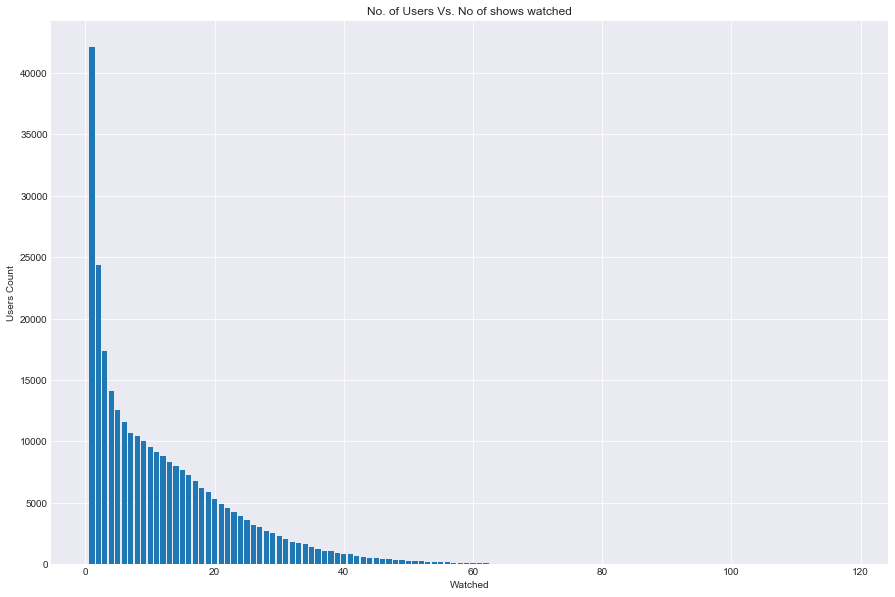

In [40]:
# style
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))

res_df = result_df[['watched','Model_050_topics0.1_w0.1_n0.1_u0.1_v500_epochs']].groupby('watched').count().reset_index()
plt.bar(res_df['watched'],res_df['Model_050_topics0.1_w0.1_n0.1_u0.1_v500_epochs'])
plt.title('No. of Users Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Users Count') 

Text(0, 0.5, 'Recall')

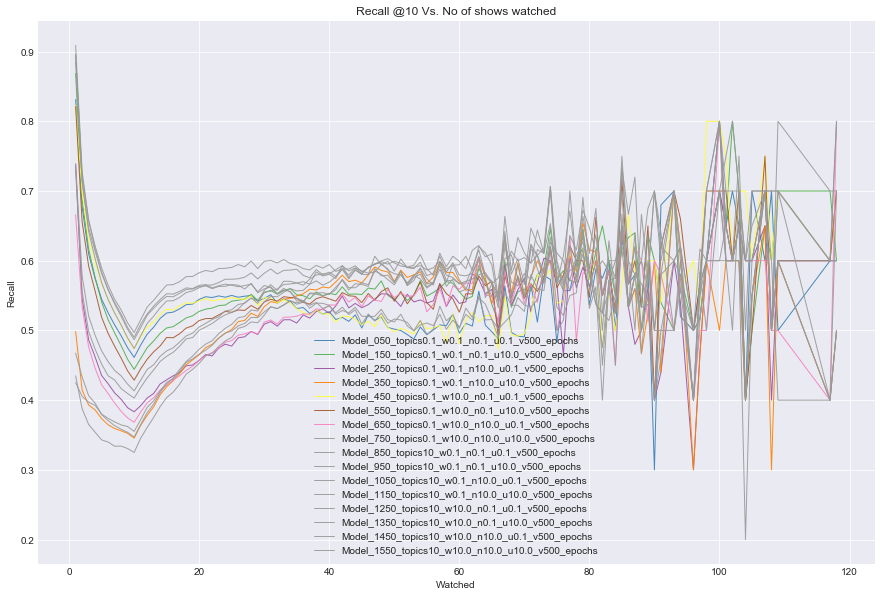

In [41]:
# style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))

num=0
for column in result_df.columns[1:]:
    num+=1
    res_df = result_df[['watched',column]].groupby('watched').mean().reset_index()
    plt.plot(res_df['watched'], res_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()
plt.title('Recall @10 Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

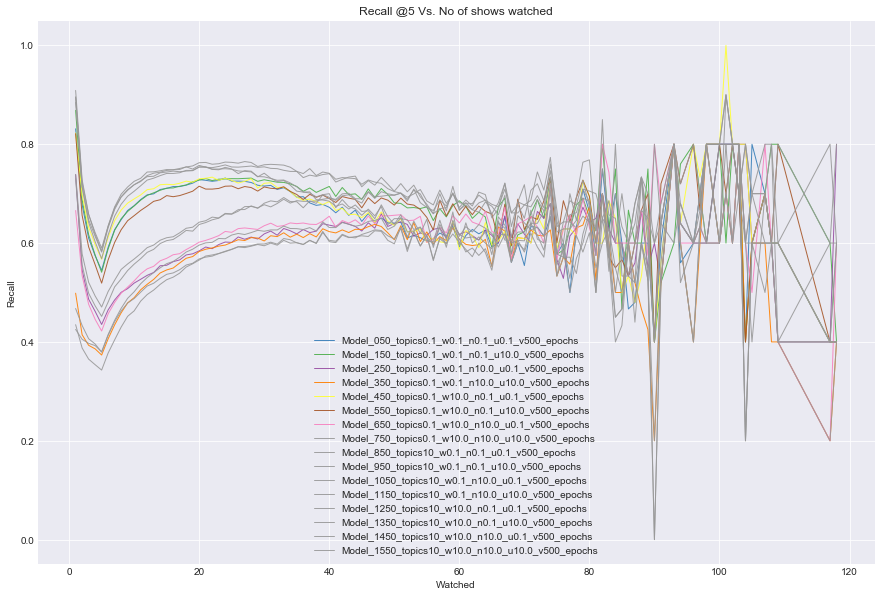

In [42]:
# style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))

num=0
for column in result_df_5.columns[1:]:
    num+=1
    res_df = result_df_5[['watched',column]].groupby('watched').mean().reset_index()
    plt.plot(res_df['watched'], res_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()
plt.title('Recall @5 Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

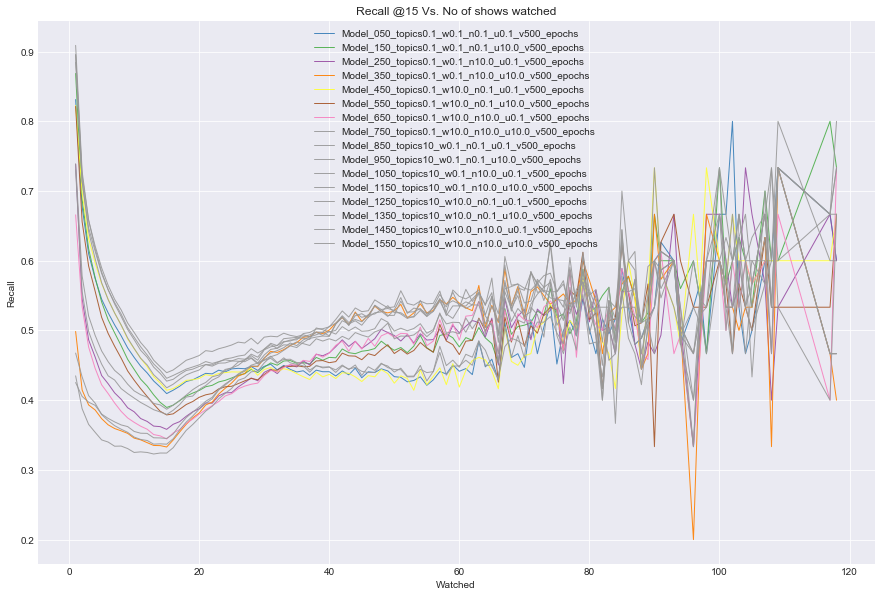

In [43]:
# style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))

num=0
for column in result_df_15.columns[1:]:
    num+=1
    res_df = result_df_15[['watched',column]].groupby('watched').mean().reset_index()
    plt.plot(res_df['watched'], res_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()
plt.title('Recall @15 Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Recall')

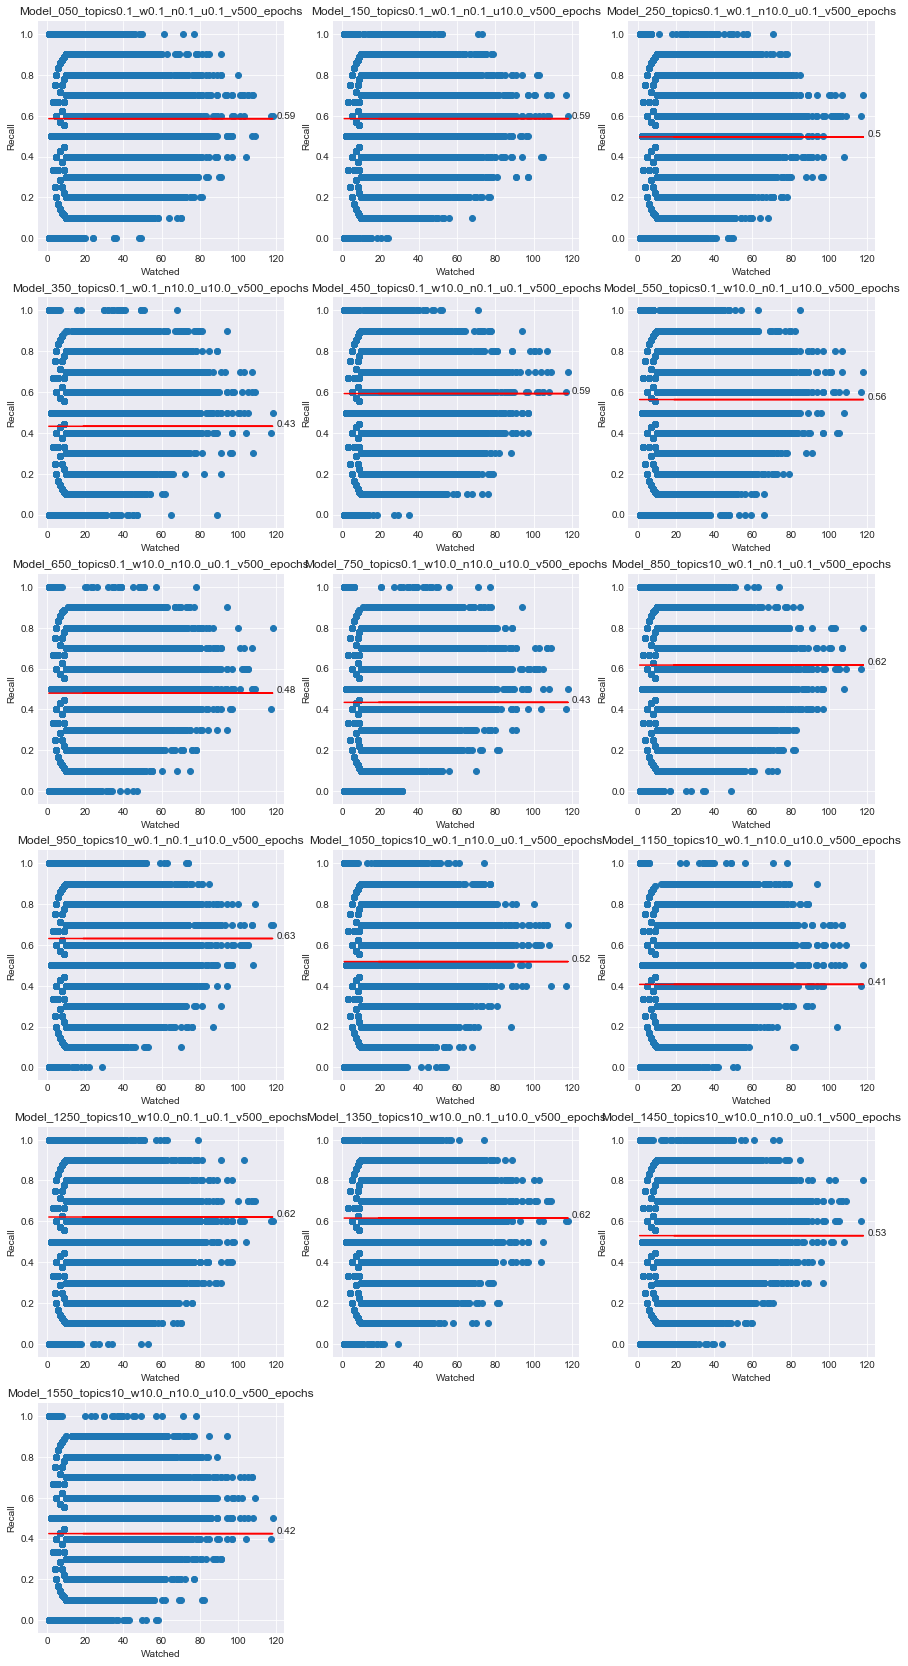

In [44]:
plt.figure(figsize=(15,50))
plt.title('Recall vs Watched by model & Avg. Recall') 
for i in range(len(result_array)):
    plt.subplot(10,3,i+1)
    plt.xlabel('Watched')
    plt.ylabel('Recall') 
    
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    plt.title(model_string)
#     result_df[['watched',model_string]].plot(x= 'watched', y = model_string)
    plt.scatter(x= 'watched', y = model_string,data=result_df)
    mean_val  = np.mean(result_df[model_string])
    plt.plot(result_df['watched'],[mean_val for i in range(len(result_df['watched']))], 'r-')
    plt.text(120, mean_val,str(round(mean_val,2)))


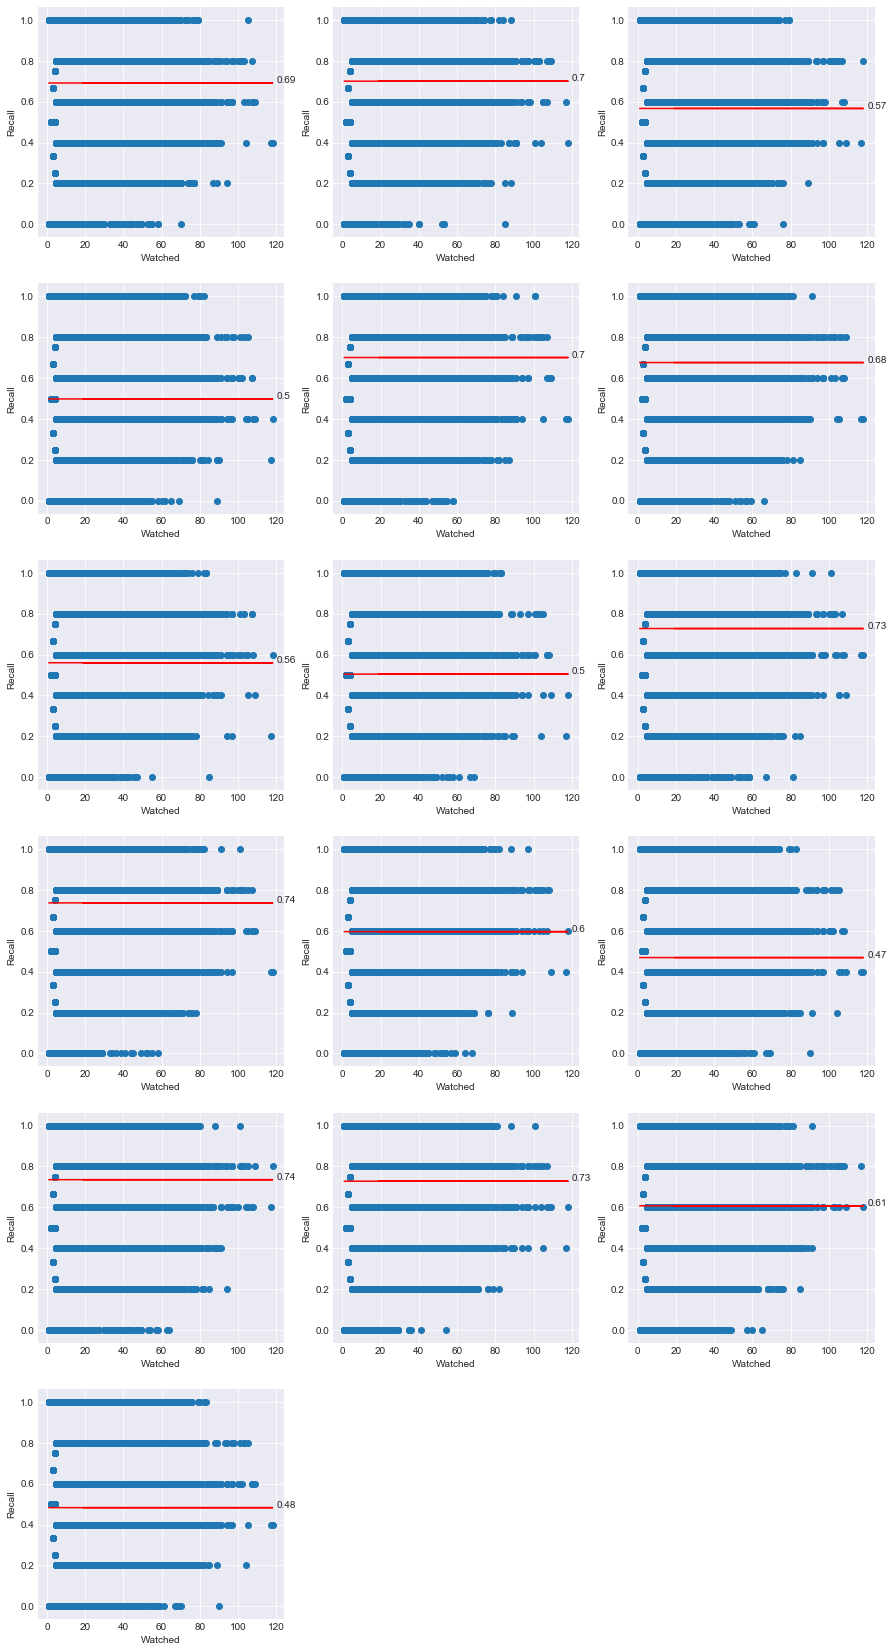

In [45]:
plt.figure(figsize=(15,50))
plt.title('Recall vs Watched by model & Avg. Recall') 
for i in range(len(result_array)):
    plt.subplot(10,3,i+1)
    plt.xlabel('Watched')
    plt.ylabel('Recall') 
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
#     result_df[['watched',model_string]].plot(x= 'watched', y = model_string)
    plt.scatter(x= 'watched', y = model_string,data=result_df_5)
    mean_val  = np.mean(result_df_5[model_string])
    plt.plot(result_df_5['watched'],[mean_val for i in range(len(result_df_5['watched']))], 'r-')
    plt.text(120, mean_val,str(round(mean_val,2)))

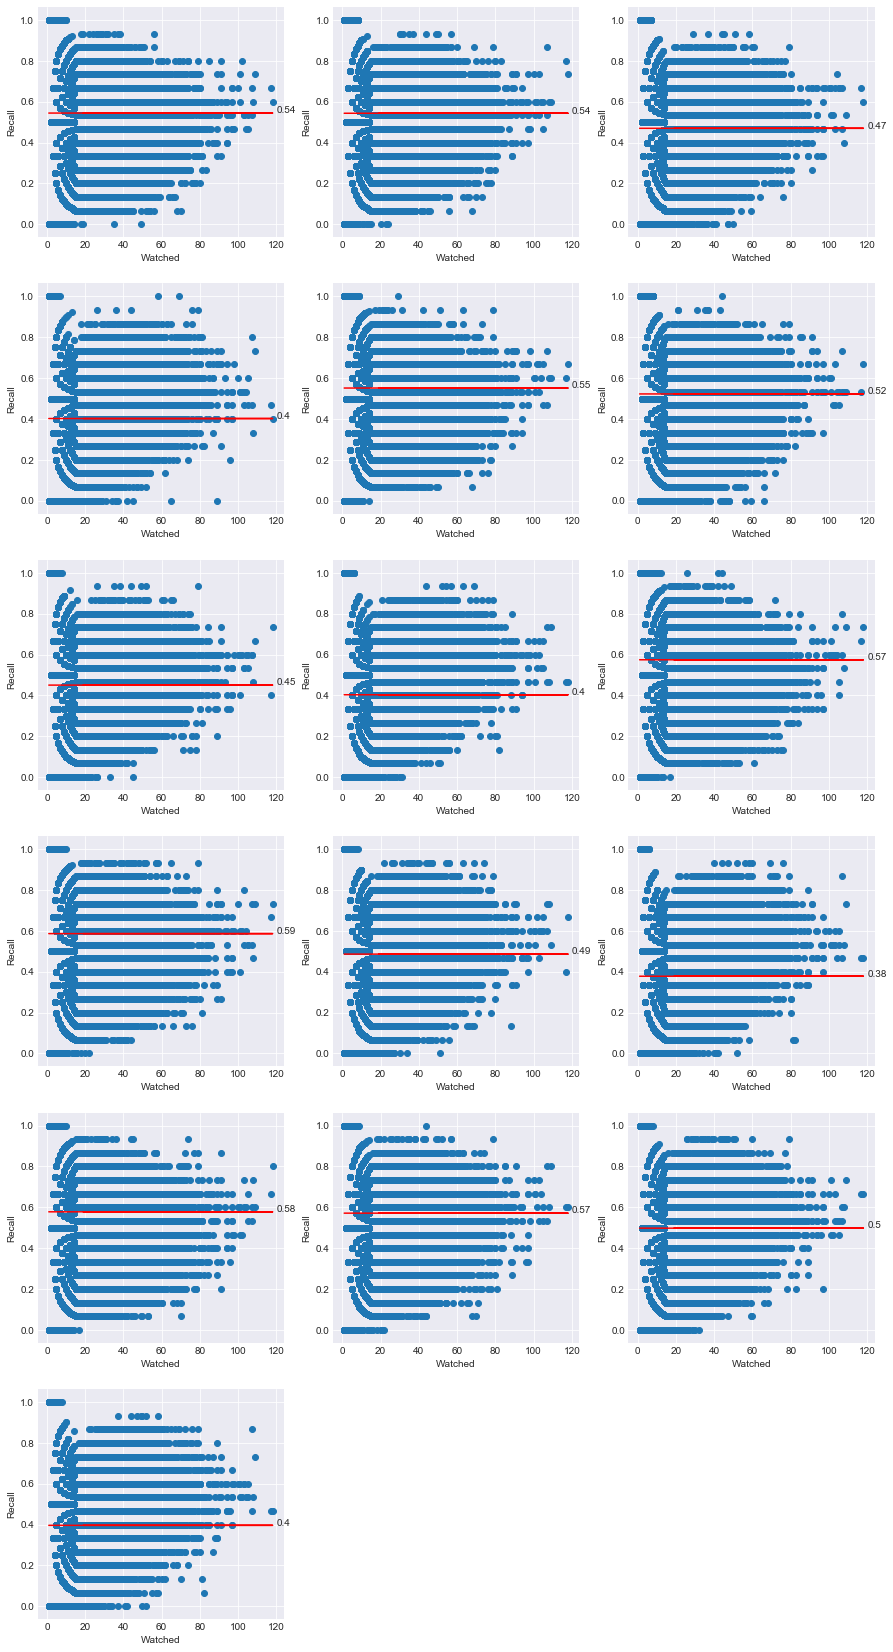

In [46]:
plt.figure(figsize=(15,50))
plt.title('Recall vs Watched by model & Avg. Recall') 
for i in range(len(result_array)):
    plt.subplot(10,3,i+1)
    plt.xlabel('Watched')
    plt.ylabel('Recall') 
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
#     result_df[['watched',model_string]].plot(x= 'watched', y = model_string)
    plt.scatter(x= 'watched', y = model_string,data=result_df_15)
    mean_val  = np.mean(result_df_15[model_string])
    plt.plot(result_df_15['watched'],[mean_val for i in range(len(result_df_15['watched']))], 'r-')
    plt.text(120, mean_val,str(round(mean_val,2)))

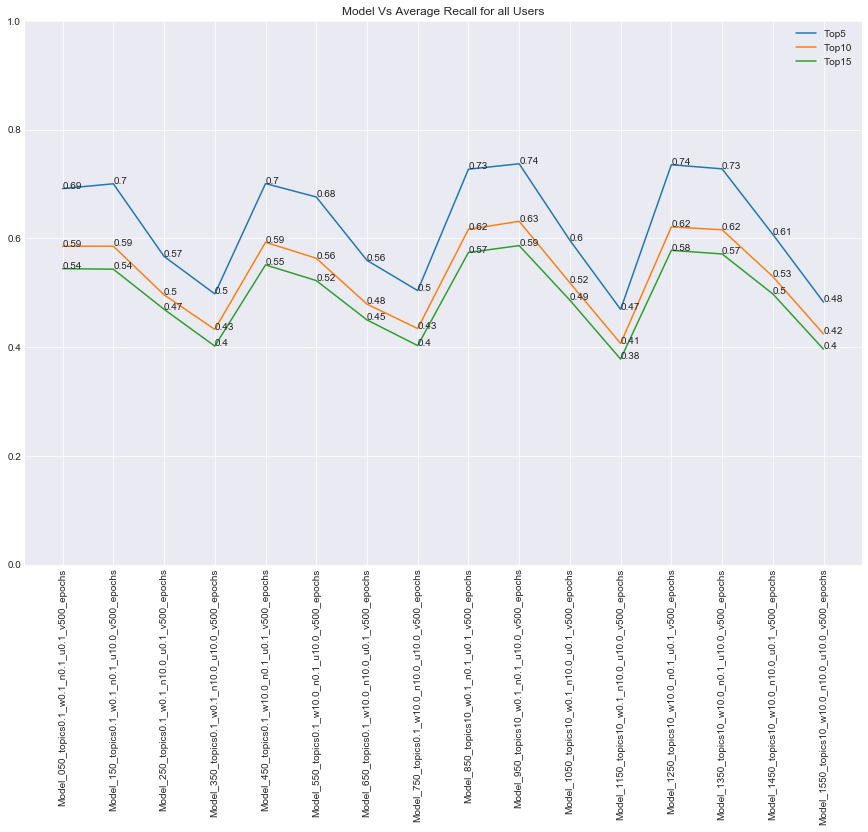

In [48]:
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("The Big Bang Theory")
avg_recall_df = pd.DataFrame(result_df[result_df.columns[result_df.columns != 'watched']].mean().reset_index())
avg_recall_df_5 = pd.DataFrame(result_df_5[result_df_5.columns[result_df_5.columns != 'watched']].mean().reset_index())
avg_recall_df_15 = pd.DataFrame(result_df_15[result_df_15.columns[result_df_15.columns != 'watched']].mean().reset_index())

avg_recall_df.columns = ['name','sum']
avg_recall_df_5.columns = ['name','sum']
avg_recall_df_15.columns = ['name','sum']

original_watchers = len(np.where(np.array(AllData_test_run_pivot_df_Original.iloc[:,series_loc])>0.0)[0])
avg_recall_df['original'] = [original_watchers for i in range(len(avg_recall_df))]
avg_recall_df_5['original'] = [original_watchers for i in range(len(avg_recall_df_5))]
avg_recall_df_15['original'] = [original_watchers for i in range(len(avg_recall_df_15))]
# avg_recall_df['index_column'] = [i[:len(i)-5] if  i[len(i)-5:len(i)-4] == '_'  else  i[:len(i)-6]  for i in avg_recall_df.name ]
plt.figure(figsize = (15,10))

plt.plot('name','sum',data = avg_recall_df_5,label = 'Top5')
for i,j in zip(range(len(avg_recall_df_5.name)),avg_recall_df_5['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j))
plt.plot('name','sum',data = avg_recall_df, label = 'Top10')
for i,j in zip(range(len(avg_recall_df.name)),avg_recall_df['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j))
plt.plot('name','sum',data = avg_recall_df_15,label ='Top15')
for i,j in zip(range(len(avg_recall_df_15.name)),avg_recall_df_15['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j))
    
plt.title("Model Vs Average Recall for all Users")
plt.xticks(rotation = 90)
plt.ylim([0,1])
plt.legend()

In [49]:
# present_list = []
def calculate_present_or_not(inp_original_arr,inp_predicted_arr,inp_threshold,inp_series_loc) :

    def present_calculations(original_arr,predicted_arr,threshold,present_list,series_loc): 
        for i in range(len(original_arr)):
            rank_10 = np.argsort(original_arr[i,:])[-threshold:]
            if (predicted_arr[i,series_loc] > np.min(predicted_arr[i,:][rank_10])) and (original_arr[i,series_loc] > 0.0):
                present_list.append(1)
            else:
                present_list.append(0)
            
    import multiprocessing
    procs = 1   # Number of processes to create
    manager = multiprocessing.Manager()
    present_list = manager.list()
    jobs = []
        # recall_list = list()
    for i in range(0, procs):
        process = multiprocessing.Process(target=present_calculations,args=(np.array(inp_original_arr),inp_predicted_arr,inp_threshold,present_list,inp_series_loc))
        jobs.append(process)
    for j in jobs:
        j.start()
    for j in jobs:
        j.join()
    print("List processing complete.")
    return present_list

In [50]:
def generate_present_or_not(n_top, series_location,dataframe):
    for i in range(len(result_array)):
        model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"      
        column_name  = model_string+'_Top'+str(n_top)
        dataframe[column_name] = calculate_present_or_not(AllData_test_run_pivot_df_Original,result_array[i],n_top,series_location)

In [51]:
present_or_not_df = pd.DataFrame({"watched":watched})
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("The Big Bang Theory")
generate_present_or_not(5, series_loc,present_or_not_df)
generate_present_or_not(10, series_loc,present_or_not_df)
generate_present_or_not(15, series_loc,present_or_not_df)

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List process

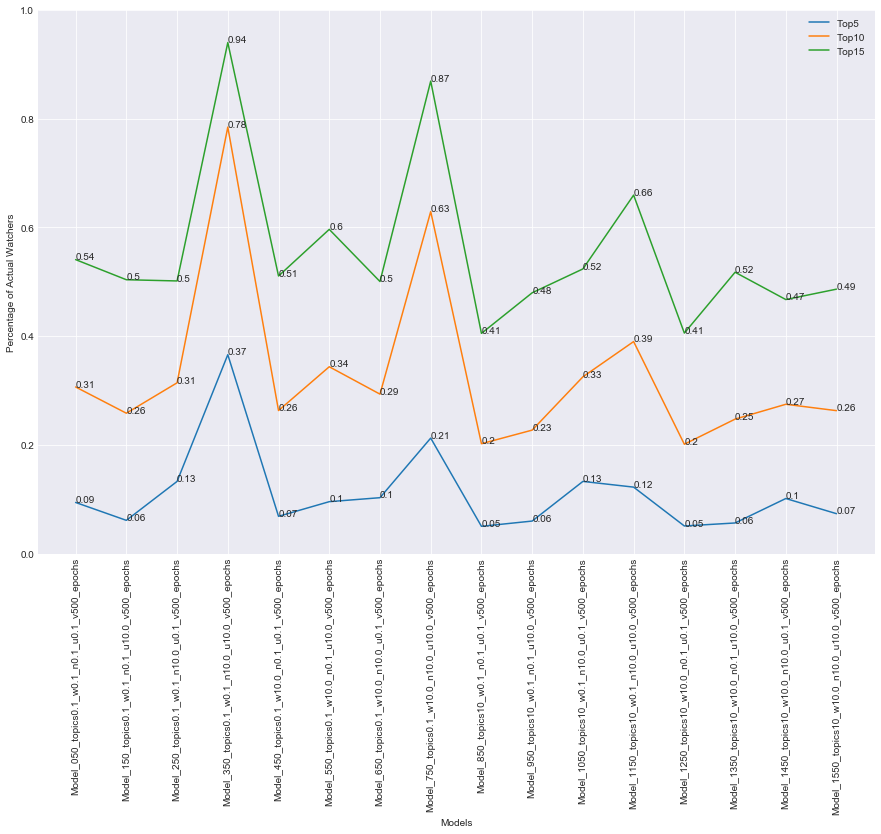

In [52]:
final_df = pd.DataFrame(present_or_not_df[present_or_not_df.columns[present_or_not_df.columns != 'watched']].sum().reset_index())
final_df.columns = ['name','sum']
original_watchers = len(np.where(np.array(AllData_test_run_pivot_df_Original.iloc[:,series_loc])>0.0)[0])
final_df['original'] = [original_watchers for i in range(len(final_df))]
final_df['index_column'] = [i[:len(i)-5] if  i[len(i)-5:len(i)-4] == '_'  else  i[:len(i)-6]  for i in final_df.name ]

top5_data = [name_val.endswith('_Top5') for name_val in final_df.name]
top10_data = [name_val.endswith('_Top10') for name_val in final_df.name]
top15_data = [name_val.endswith('_Top15') for name_val in final_df.name]

final_df['pct'] = final_df['sum']/final_df['original']
final_top5_data = final_df[top5_data].reset_index()
final_top10_data = final_df[top10_data].reset_index()
final_top15_data = final_df[top15_data].reset_index()

plt.figure(figsize = (15,10))
plt.plot('index_column', 'pct' ,data=final_top5_data,label = 'Top5')
plt.plot('index_column', 'pct' ,data=final_top10_data,label = 'Top10')
plt.plot('index_column', 'pct' ,data=final_top15_data,label = 'Top15')

for i,j in zip(range(len(final_top5_data.index_column)),final_top5_data['pct']):
    plt.annotate(str(round(j,2)),xy=(i,j))

for i,j in zip(range(len(final_top10_data.index_column)),final_top10_data['pct']):
    plt.annotate(str(round(j,2)),xy=(i,j))

for i,j in zip(range(len(final_top15_data.index_column)),final_top15_data['pct']):
    plt.annotate(str(round(j,2)),xy=(i,j))
    
plt.xlabel('Models')
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel('Percentage of Actual Watchers') 
plt.legend()        